## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Importing Libraries</p>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import mode
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, classification_report, 
    confusion_matrix, accuracy_score, matthews_corrcoef, f1_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedShuffleSplit,
    StratifiedKFold, train_test_split, cross_val_score, cross_validate
)
import warnings
warnings.filterwarnings('ignore')

  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Loading data</p>

In [2]:
cd /workspace/data/

/workspace/data


In [3]:
train_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/train.csv"))
test_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/test.csv"))
sample_submission_data = pd.read_csv(os.path.join(os.getcwd(), "kaggle/playground-series-s4e8/sample_submission.csv"))

print("train_data :", train_data.shape)
print("test_data :", test_data.shape)
print("sample_submission_data :", sample_submission_data.shape)

train_data : (3116945, 22)
test_data : (2077964, 21)
sample_submission_data : (2077964, 2)


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Basic Info about Data</p> 

In [4]:
train_data.head(2)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [5]:
test_data.head(2)

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a


In [6]:
sample_submission_data.head(2)

,id,class
0,3116945,e
1,3116946,e


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3116945.0,1.558472e+06,899784.661737,0.00,779236.00,1558472.00,2337708.00,3116944.00
cap-diameter,3116941.0,6.309848e+00,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333e+00,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,1.115379e+01,8.095477,0.00,4.97,9.65,15.63,102.90


class
p    1705396
e    1411549
Name: count, dtype: int64
class
p    0.547137
e    0.452863
Name: count, dtype: float64


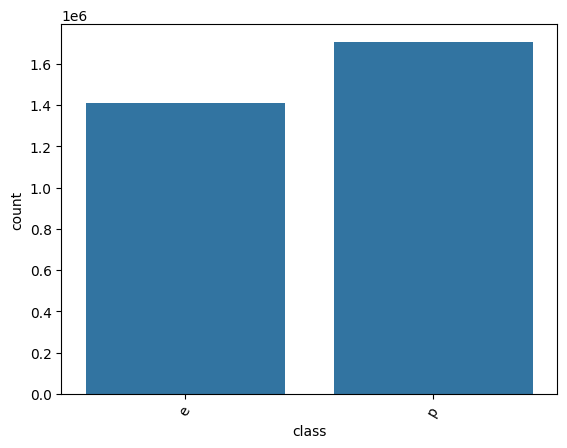

In [9]:
print(train_data['class'].value_counts())
print(train_data['class'].value_counts() / sum(train_data['class'].value_counts()))
sns.countplot(x='class',data=train_data)
plt.xticks(rotation=60)
plt.show()

In [10]:
pd.DataFrame({
    'column': train_data.columns,
    'null-count': train_data.isna().sum().values,
    '% null-count': np.round(train_data.isna().sum().values*100/len(train_data),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,2957493,94.884350
1,spore-print-color,2849682,91.425482
2,stem-root,2757023,88.452732
3,veil-color,2740947,87.936970
4,stem-surface,1980861,63.551362
5,gill-spacing,1258435,40.373988
6,cap-surface,671023,21.528227
7,gill-attachment,523936,16.809280
8,ring-type,128880,4.134818
9,gill-color,57,0.001829


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Correlation Matrics</p> 

In [ ]:
# train_data.replace(['NaN', 'None', 'null', ''], np.nan, inplace=True)
df_dropped = train_data.drop('id', axis=1)
df_encoded = df_dropped.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)
train_data.isna().sum()

correlation_matrix = df_encoded.corr()

correlation_matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Checking Unique Categories
</p> 

In [ ]:
# cate_col = train_data.select_dtypes(include=['object']).columns

# # Find unique categories and their counts for each categorical column
# unique_categories = {col: train_data[col].value_counts() for col in cate_col}

# # Set the size of the overall figure
# plt.figure(figsize=(15, len(cate_col) * 5))

# # Plot the count of each unique category
# for i, (col, counts) in enumerate(unique_categories.items(), 1):
#     plt.subplot(len(cate_col), 1, i)
#     sns.barplot(x=counts.index, y=counts.values, palette="viridis")
#     plt.title(f"Count of unique categories in column '{col}'")
#     plt.xlabel('Categories')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()

# plt.show()


  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Percentage of Missing Values by Feature</p>

In [20]:
pd.DataFrame({
    'column': train_data.drop('id', axis=1).columns,
    'null-count': train_data.drop('id', axis=1).isna().sum().values,
    '% null-count': np.round(train_data.drop('id', axis=1).isna().sum().values*100/len(train_data.drop('id', axis=1)),6),
    'test null-count': test_data.isna().sum().values,
    '% test null-count': np.round(test_data.isna().sum().values*100/len(test_data),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count,test null-count,% test null-count
0,veil-type,2957493,94.884350,1971545,94.878689
1,spore-print-color,2849682,91.425482,1899617,91.417224
2,stem-root,2757023,88.452732,1838012,88.452543
3,veil-color,2740947,87.936970,1826124,87.880445
4,stem-surface,1980861,63.551362,1321488,63.595327
5,gill-spacing,1258435,40.373988,839595,40.404694
6,cap-surface,671023,21.528227,446904,21.506821
7,gill-attachment,523936,16.809280,349821,16.834796
8,ring-type,128880,4.134818,86195,4.148051
9,gill-color,57,0.001829,49,0.002358


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Checking Feature Importance and Dropping Useless Columns
</p> 

In [ ]:
# alpha = 0.05
# values = {}

# for col in train_data.columns:
#     if col == "class":
#         continue

#     A, B = train_data[col], train_data["class"]

#     dfObserved = pd.crosstab(A, B) 
#     chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values) # 카이제곱 독립 검정 수행
#     values[col] = p
#     if p < alpha:
#         # Reject null hypothesis
#         print("{} is important. (p = {})".format(col, p))
#     else:
#         # Accept null hypothesis
#         print("{} is NOT important. (p = {})".format(col, p))

In [7]:
# Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
#        'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
#        'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
#        'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
#        'habitat', 'season', 'veil-info'],
#       dtype='object')

# 결측치와 특성 존재 여부를 동시에 다룰 수 있음: 앞에서 0과 1로 veil-type의 존재 여부를 표현하고, 뒤에서 'unknown'을 통해 veil-color의 결측치를 처리함으로써 두 정보를 효과적으로 결합할 수 있습니다.
# 모델 학습에 유용한 정보 제공: 결측치나 특성의 존재 여부를 단순히 무시하지 않고, 이들을 결합하여 모델이 더 많은 패턴을 학습할 수 있게 도와줍니다.
# Index(['w', 'y', 'n', 'u', 'k', 'e', 'g', 'p', 'r', 'o', 's', 'a', 't', 'd',
#        'i', 'h', 'c', 'f', 'l', 'b', 'z', '8.25', '2.49', '3.32'],
#       dtype='object', name='veil-color')
# Index(['u', 'w', 'a', 'f', 'e', 'b', 'c', 'y', 'k', 'g', 'n', 's', 'r', 'd',
#        'p', 'h', 'i', 'l', 'is None', 't', '21.11', '5.94'],
#       dtype='object', name='veil-type')

# Index(['f10', 'tnone', 't1', 't7', 't10', 't4', 't2', 't5', 't3', 't9',
#        'fnone', 'f1', 'f2', 'f7', 'f4', 't8', 'f5', 'r2', 't6', 'f3', 'l4',
#        't0', 'p5', 'z7', 'c10', 'x10', 'f9', 'f6', 's10', 'm9', 'hnone', 's1',
#        'g3', 'g5', 'h7', 'e1', 'f0', 'r4', 'dnone', 's5', 'cnone', 'h1', 'p1',
#        'h5', 'h10', 'w3', 'y2', 'a10', 'ynone', 'e10', 'p7', '10.310', 's2',
#        'o2', 'g10', 'h2', 'g1', 's3', 'p3', 'knone', 'inone', 'nnone', 'rnone',
#        'l5', 'c1', 'n10', 'c3', 'o10', 'e4', 'd10', 'f has-ring10', 'lnone',
#        'c7', 'e3', 'y1', 'k10'],
#       dtype='object', name='has-ring-type')

train_data['veil-info'] = train_data['veil-type'].notna().astype(int).astype(str) + train_data['veil-color'].fillna('unknown')
cap_shape_mapping = {'b': 0, 'c': 1, 'x': 2, 'f': 3, 's': 4, 'p': 5, 'o': 6}
cap_color_mapping = {'n': 0, 'b': 1, 'g': 2, 'r': 3, 'p': 4, 'u': 5, 'e': 6, 'w': 7, 'y': 8, 'l': 9, 'o': 10, 'k': 11}
ring_type_mapping = {'c': 0, 'e': 1, 'r': 2, 'g': 3, 'l': 4, 'p': 5, 's': 6, 'z': 7, 'y': 8, 'm': 9, 'f': 10}
train_data['cap-shape'] = train_data['cap-shape'].map(cap_shape_mapping).astype(str).str.replace('.0', '', regex=False)
train_data['cap-color'] = train_data['cap-color'].map(cap_color_mapping).astype(str).str.replace('.0', '', regex=False)
train_data['has-ring-type'] = (
    train_data['has-ring'] + 
    train_data['ring-type'].fillna('none').map(ring_type_mapping).apply(lambda x: f"{x:.0f}" if pd.notna(x) else 'none').str.replace('.0', '', regex=False)
)

test_data['veil-info'] = test_data['veil-type'].notna().astype(int).astype(str) + test_data['veil-color'].fillna('unknown')
test_data['cap-shape'] = test_data['cap-shape'].map(cap_shape_mapping).astype(str).str.replace('.0', '', regex=False)
test_data['cap-color'] = test_data['cap-color'].map(cap_color_mapping).astype(str).str.replace('.0', '', regex=False)
test_data['has-ring-type'] = (
    test_data['has-ring'] + 
    test_data['ring-type'].fillna('none').map(ring_type_mapping).apply(lambda x: f"{x:.0f}" if pd.notna(x) else 'none').str.replace('.0', '', regex=False)
)

In [8]:
train_data['has-ring-type']

0          f10
1           t7
2          f10
3          f10
4          f10
          ... 
3116940     t3
3116941    f10
3116942     t7
3116943     t5
3116944    f10
Name: has-ring-type, Length: 3116945, dtype: object

In [9]:
set(train_data['veil-info'])

{'02.49',
 '03.32',
 '08.25',
 '0a',
 '0b',
 '0c',
 '0d',
 '0e',
 '0f',
 '0g',
 '0h',
 '0i',
 '0k',
 '0l',
 '0n',
 '0o',
 '0p',
 '0r',
 '0s',
 '0t',
 '0u',
 '0unknown',
 '0w',
 '0y',
 '1g',
 '1h',
 '1k',
 '1n',
 '1r',
 '1t',
 '1u',
 '1unknown',
 '1w',
 '1y',
 '1z'}

In [10]:
train_data = train_data.drop(['id', 'veil-color', 'veil-type', 'has-ring', 'ring-type'], axis=1)
test_data = test_data.drop(['id', 'veil-color', 'veil-type', 'has-ring', 'ring-type'], axis=1)

In [16]:
# df_encoded = train_data
# dt_encoded = test_data

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Handling NaN Values And Less Frequent Categories</p> 

In [17]:
# columns_to_fill_train = train_data.columns[(train_data.isna().sum() > 0) & (train_data.isna().sum() < 60)].tolist()
# columns_to_fill_test = test_data.columns[(test_data.isna().sum() > 0) & (test_data.isna().sum() < 100)].tolist()

# corr_matrix_train = df_encoded.corr()
# corr_matrix_test = dt_encoded.corr()

# def fill_missing_values(data, columns_to_fill, corr_matrix):
#     for column in columns_to_fill:
#         if column in corr_matrix.columns:
#             most_corr_features = corr_matrix[column][corr_matrix[column].abs() > 0.1].index.tolist()
#             if column in most_corr_features:
#                 most_corr_features.remove(column)

#             if most_corr_features:
#                 group_modes = data.groupby(most_corr_features)[column].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

#                 def fill_na(row):
#                     if pd.isna(row[column]):
#                         try:
#                             return group_modes.loc[tuple(row[most_corr_features])]
#                         except KeyError:
#                             return np.nan
#                     else:
#                         return row[column]

#                 data[column] = data.apply(fill_na, axis=1)

# fill_missing_values(df_encoded, columns_to_fill_train, corr_matrix_train)
# fill_missing_values(dt_encoded, columns_to_fill_test, corr_matrix_test)


In [18]:
train_data.isna().sum()

class                         0
cap-diameter                  4
cap-shape                     0
cap-surface              671023
cap-color                     0
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
spore-print-color       2849682
habitat                      45
season                        0
veil-info                     0
has-ring-type                24
dtype: int64

In [19]:
train_data.columns[(train_data.isna().sum() > 0) & (train_data.isna().sum() < 60)].tolist()

['cap-diameter',
 'does-bruise-or-bleed',
 'gill-color',
 'stem-color',
 'habitat',
 'has-ring-type']

In [11]:
def cleaning(df):
    threshold = 100
    
    cat_feats = ['cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'spore-print-color',
       'habitat', 'season', 'veil-info', 'has-ring-type']
    
    for feat in cat_feats:
        if df[feat].dtype.name == 'category':
            # Add 'missing' and 'noise' to categories if not present
            if 'missing' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('missing')
            if 'noise' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('noise')
        else:
            # Convert to category and add new categories
            df[feat] = df[feat].astype('category')
            df[feat] = df[feat].cat.add_categories(['missing', 'noise'])
        
        # Fill missing values with 'missing'
        df[feat] = df[feat].fillna('missing')
        
        # Replace infrequent categories with 'noise'
        counts = df[feat].value_counts(dropna=False)
        infrequent_categories = counts[counts < threshold].index
        df[feat] = df[feat].apply(lambda x: 'missing' if x in infrequent_categories else x)
    
    return df

# Example usage
train_data = cleaning(train_data)
test_data = cleaning(test_data)

In [21]:
train_data.isna().sum()

class                   0
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
spore-print-color       0
habitat                 0
season                  0
veil-info               0
has-ring-type           0
dtype: int64

In [12]:
group_by_features = ['stem-width', 'stem-height']
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()
group_means_train

stem-width  stem-height
0.00        0.00            4.253239
            2.69            3.900000
            2.85            3.040000
            2.93            2.810000
            2.94            2.840000
                             ...    
102.48      26.04           9.910000
            26.38          20.490000
            26.40          27.080000
            26.44          23.710000
102.90      27.32          17.570000
Name: cap-diameter, Length: 1134552, dtype: float64

In [13]:
group_by_features = ['stem-width', 'stem-height']
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()

def fill_na_with_group_mean(row):
    if pd.isna(row['cap-diameter']):
        group = tuple(row[group_by_features])
        return group_means_train.get(group, np.nan) 
    else:
        return row['cap-diameter']

train_data['cap-diameter'] = train_data.apply(fill_na_with_group_mean, axis=1)
test_data['cap-diameter'] = test_data.apply(fill_na_with_group_mean, axis=1)

In [14]:
group_by_features = ['stem-width', 'stem-height']

# Calculate group means for the train data
group_means_train = train_data.groupby(group_by_features)['cap-diameter'].mean()

def fill_na_with_group_mean(row, group_means):
    if pd.isna(row['cap-diameter']):
        group = tuple(row[group_by_features])
        return group_means.get(group, np.nan)
    else:
        return row['cap-diameter']

# Apply to train_data using train group means
train_data['cap-diameter'] = train_data.apply(fill_na_with_group_mean, axis=1, group_means=group_means_train)

# Apply the same group means from train_data to test_data
test_data['cap-diameter'] = test_data.apply(fill_na_with_group_mean, axis=1, group_means=group_means_train)
###
###
# Calculate the mode from the training data
cap_diameter_mode = train_data['cap-diameter'].mode()[0]
stem_height_mode = train_data['stem-height'].mode()[0]

# Fill missing values in the training data using the mode calculated from the training data
train_data['cap-diameter'] = train_data['cap-diameter'].fillna(cap_diameter_mode)
train_data['stem-height'] = train_data['stem-height'].fillna(stem_height_mode)

# Fill missing values in the test data using the mode calculated from the training data
test_data['cap-diameter'] = test_data['cap-diameter'].fillna(cap_diameter_mode)
test_data['stem-height'] = test_data['stem-height'].fillna(stem_height_mode)

In [15]:
# print("Nan Values in Train data")
# print(null_percent(train_data))
# print("Nan Values in Test data")
# print(null_percent(test_data))

In [16]:
cat_feats = ['cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'spore-print-color',
       'habitat', 'season', 'veil-info', 'has-ring-type']

for feat in cat_feats:
    train_data[feat] = train_data[feat].astype('category')
for feat in cat_feats:
    test_data[feat] = test_data[feat].astype('category')

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Splitting Data</p> 

In [17]:
X = train_data.drop(['class'], axis=1)
y = train_data['class']
print(X.shape, y.shape)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y[:3])

(3116945, 18) (3116945,)
[0 1 0]


In [18]:
# Callback to print the MCC score for each trial
def print_mcc_callback(study, trial):
    mcc = trial.user_attrs["mcc"]
    print(f"Trial {trial.number}: MCC = {mcc}")

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Using XGBoost with optuna</p> 

In [40]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

    Model: XGBClassifier
F1 Score : 0.992267
MCC Score: 0.982945


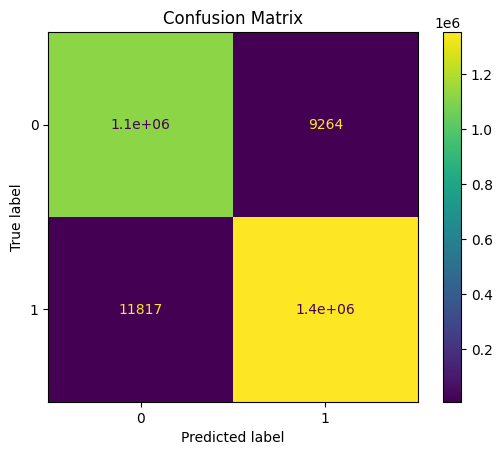

In [59]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=cat_feats,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.991328
MCC Score: 0.980880


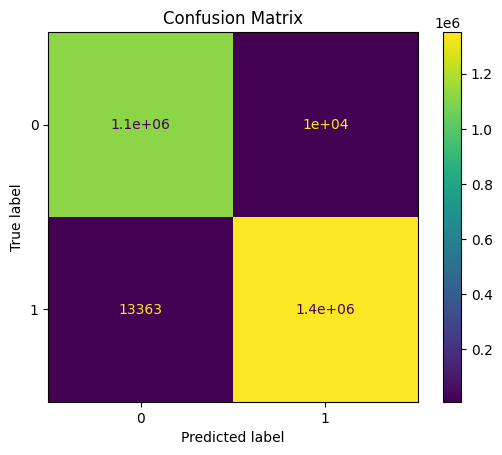

In [78]:
lgb_clf = LGBMClassifier(device='cpu', verbosity=-1)

model_report(lgb_clf, X, y)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4885)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200), #  100, 1000
        'max_depth': trial.suggest_int('max_depth', 10, 22), #5, 10
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0),
        "eta": trial.suggest_float("eta", 1e-3, 1e-2),
        "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "max_leaves": trial.suggest_int("max_leaves", 16, 84),
        'device': 'cuda',
        'tree_method': 'gpu_hist'
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', enable_categorical=True, early_stopping_rounds=10)
    # Fit the model with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        verbose=False                 # Suppress output
    )
    
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc



storage = "sqlite:///xgb.db"

# Optimize hyperparameters with Optuna
study = optuna.create_study(storage=storage,
                            direction='maximize',
                           )
study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2024-08-27 19:44:25,710] A new study created in RDB with name: no-name-72717479-5212-4da8-bca3-b02f1d65c24b
[I 2024-08-27 19:44:34,117] Trial 0 finished with value: 0.9790927628223424 and parameters: {'n_estimators': 923, 'max_depth': 11, 'learning_rate': 0.17257765077570078, 'subsample': 0.970625269545994, 'colsample_bytree': 0.9805221896522274, 'gamma': 3.536612821597278e-07, 'lambda': 0.00016635443612702703, 'alpha': 6.400165368493864e-05, 'scale_pos_weight': 7.2042472554787444, 'eta': 0.008815147164417024, 'min_child_weight': 53, 'grow_policy': 'lossguide', 'max_leaves': 69}. Best is trial 0 with value: 0.9790927628223424.


Trial 0: MCC = 0.9790927628223424


[I 2024-08-27 19:44:38,029] Trial 1 finished with value: 0.9769236861330862 and parameters: {'n_estimators': 680, 'max_depth': 7, 'learning_rate': 0.06627817354783079, 'subsample': 0.6398204999991215, 'colsample_bytree': 0.7591967453531012, 'gamma': 9.269677662294016e-05, 'lambda': 0.8191913000628114, 'alpha': 0.00843333880308286, 'scale_pos_weight': 8.166067246540702, 'eta': 0.008298462260109836, 'min_child_weight': 47, 'grow_policy': 'depthwise', 'max_leaves': 67}. Best is trial 0 with value: 0.9790927628223424.


Trial 1: MCC = 0.9769236861330862


[I 2024-08-27 19:44:42,318] Trial 2 finished with value: 0.9792737220574944 and parameters: {'n_estimators': 392, 'max_depth': 20, 'learning_rate': 0.19272018875006747, 'subsample': 0.6762886178659704, 'colsample_bytree': 0.8624107899158042, 'gamma': 0.0009872949076317648, 'lambda': 1.1239762156698203e-06, 'alpha': 0.010045184989652664, 'scale_pos_weight': 5.5920284431227385, 'eta': 0.0058705856432691265, 'min_child_weight': 92, 'grow_policy': 'lossguide', 'max_leaves': 74}. Best is trial 2 with value: 0.9792737220574944.


Trial 2: MCC = 0.9792737220574944


[I 2024-08-27 19:44:45,271] Trial 3 finished with value: 0.9832354481212188 and parameters: {'n_estimators': 583, 'max_depth': 16, 'learning_rate': 0.2792375321265815, 'subsample': 0.5939722891835694, 'colsample_bytree': 0.5822668716485564, 'gamma': 0.040184398789382014, 'lambda': 1.311587136861228e-07, 'alpha': 0.02791615181120941, 'scale_pos_weight': 1.8751784375977165, 'eta': 0.006711743358769515, 'min_child_weight': 87, 'grow_policy': 'lossguide', 'max_leaves': 33}. Best is trial 3 with value: 0.9832354481212188.


Trial 3: MCC = 0.9832354481212188


[I 2024-08-27 19:44:49,863] Trial 4 finished with value: 0.9836808315715777 and parameters: {'n_estimators': 623, 'max_depth': 16, 'learning_rate': 0.08851592345467464, 'subsample': 0.5512594993091757, 'colsample_bytree': 0.630708024319111, 'gamma': 3.5938637883264136e-07, 'lambda': 4.194459179175995e-05, 'alpha': 2.76840110331879e-08, 'scale_pos_weight': 1.4077258283194554, 'eta': 0.008967386144156295, 'min_child_weight': 92, 'grow_policy': 'lossguide', 'max_leaves': 21}. Best is trial 4 with value: 0.9836808315715777.


Trial 4: MCC = 0.9836808315715777


[I 2024-08-27 19:44:52,198] Trial 5 finished with value: 0.9686950887837794 and parameters: {'n_estimators': 418, 'max_depth': 6, 'learning_rate': 0.034047447613894166, 'subsample': 0.7209961019367275, 'colsample_bytree': 0.8574265861703332, 'gamma': 0.004311385276606637, 'lambda': 7.072512553238136e-07, 'alpha': 5.184843133295116e-07, 'scale_pos_weight': 1.9564914819217436, 'eta': 0.00426025647312388, 'min_child_weight': 59, 'grow_policy': 'depthwise', 'max_leaves': 23}. Best is trial 4 with value: 0.9836808315715777.


Trial 5: MCC = 0.9686950887837794


[I 2024-08-27 19:44:56,423] Trial 6 finished with value: 0.9736149394871542 and parameters: {'n_estimators': 465, 'max_depth': 20, 'learning_rate': 0.03430096905276328, 'subsample': 0.787793721883888, 'colsample_bytree': 0.617823229182163, 'gamma': 0.000634059713261809, 'lambda': 3.607548194387068, 'alpha': 7.58927207126073e-05, 'scale_pos_weight': 8.032278096437636, 'eta': 0.00886802790297506, 'min_child_weight': 95, 'grow_policy': 'lossguide', 'max_leaves': 27}. Best is trial 4 with value: 0.9836808315715777.


Trial 6: MCC = 0.9736149394871542


[I 2024-08-27 19:44:58,527] Trial 7 finished with value: 0.9699404910331347 and parameters: {'n_estimators': 620, 'max_depth': 3, 'learning_rate': 0.18817147514488045, 'subsample': 0.6039526251611438, 'colsample_bytree': 0.7493047643383072, 'gamma': 0.1718060488796442, 'lambda': 2.7876486136709825e-05, 'alpha': 0.022903130726730826, 'scale_pos_weight': 9.278877348806539, 'eta': 0.006426055211994317, 'min_child_weight': 66, 'grow_policy': 'lossguide', 'max_leaves': 19}. Best is trial 4 with value: 0.9836808315715777.


Trial 7: MCC = 0.9699404910331347


[I 2024-08-27 19:45:00,489] Trial 8 finished with value: 0.9015005020125887 and parameters: {'n_estimators': 331, 'max_depth': 7, 'learning_rate': 0.015221844125974575, 'subsample': 0.9216098671597432, 'colsample_bytree': 0.5495571601476421, 'gamma': 3.243078759455189e-06, 'lambda': 0.00944654475444027, 'alpha': 0.006291917841656144, 'scale_pos_weight': 3.660436194756219, 'eta': 0.0030519979760487933, 'min_child_weight': 70, 'grow_policy': 'depthwise', 'max_leaves': 34}. Best is trial 4 with value: 0.9836808315715777.


Trial 8: MCC = 0.9015005020125887


[I 2024-08-27 19:45:08,775] Trial 9 finished with value: 0.9812120853926939 and parameters: {'n_estimators': 505, 'max_depth': 12, 'learning_rate': 0.013406760692233156, 'subsample': 0.9617572914901709, 'colsample_bytree': 0.5455893571438932, 'gamma': 2.4965164391417465e-06, 'lambda': 1.6860949552533362, 'alpha': 0.012822314345236216, 'scale_pos_weight': 2.5208426235301173, 'eta': 0.008616113505865391, 'min_child_weight': 55, 'grow_policy': 'lossguide', 'max_leaves': 77}. Best is trial 4 with value: 0.9836808315715777.


Trial 9: MCC = 0.9812120853926939


[I 2024-08-27 19:45:11,780] Trial 10 finished with value: 0.9802499762054764 and parameters: {'n_estimators': 830, 'max_depth': 15, 'learning_rate': 0.08361206018252351, 'subsample': 0.5072098539449942, 'colsample_bytree': 0.6764860327676416, 'gamma': 1.7065357869390116e-08, 'lambda': 0.006350389893704477, 'alpha': 6.354885373960358, 'scale_pos_weight': 4.674607773977405, 'eta': 0.009818681467199974, 'min_child_weight': 82, 'grow_policy': 'depthwise', 'max_leaves': 49}. Best is trial 4 with value: 0.9836808315715777.


Trial 10: MCC = 0.9802499762054764


[I 2024-08-27 19:45:13,857] Trial 11 finished with value: 0.9829882675781487 and parameters: {'n_estimators': 151, 'max_depth': 16, 'learning_rate': 0.10073021578449295, 'subsample': 0.5136076678497645, 'colsample_bytree': 0.62046758036212, 'gamma': 0.4621537928942569, 'lambda': 1.2672665505518533e-08, 'alpha': 1.0025353098977625e-08, 'scale_pos_weight': 1.3670833075202788, 'eta': 0.006729464176200075, 'min_child_weight': 82, 'grow_policy': 'lossguide', 'max_leaves': 41}. Best is trial 4 with value: 0.9836808315715777.


Trial 11: MCC = 0.9829882675781487


[I 2024-08-27 19:45:17,408] Trial 12 finished with value: 0.9840628786515158 and parameters: {'n_estimators': 797, 'max_depth': 16, 'learning_rate': 0.2755207374558908, 'subsample': 0.5800719843473812, 'colsample_bytree': 0.5163094494374223, 'gamma': 0.016248552638108656, 'lambda': 1.4743778345797311e-08, 'alpha': 3.247748118097652, 'scale_pos_weight': 1.036485815698887, 'eta': 0.007401911521573773, 'min_child_weight': 83, 'grow_policy': 'lossguide', 'max_leaves': 16}. Best is trial 12 with value: 0.9840628786515158.


Trial 12: MCC = 0.9840628786515158


[I 2024-08-27 19:45:21,034] Trial 13 finished with value: 0.9811685568910534 and parameters: {'n_estimators': 776, 'max_depth': 14, 'learning_rate': 0.11970975295454034, 'subsample': 0.7938278317141192, 'colsample_bytree': 0.5194539090822565, 'gamma': 4.096030711581318e-05, 'lambda': 1.9436281637566477e-05, 'alpha': 0.8141866185916464, 'scale_pos_weight': 3.5748677457474685, 'eta': 0.0014712553891612313, 'min_child_weight': 99, 'grow_policy': 'lossguide', 'max_leaves': 17}. Best is trial 12 with value: 0.9840628786515158.


Trial 13: MCC = 0.9811685568910534


[I 2024-08-27 19:45:30,811] Trial 14 finished with value: 0.9822030552789985 and parameters: {'n_estimators': 750, 'max_depth': 18, 'learning_rate': 0.04428858161359318, 'subsample': 0.5621701539742142, 'colsample_bytree': 0.6825093234055943, 'gamma': 1.7712898379575152e-08, 'lambda': 1.1298179899402646e-08, 'alpha': 2.0973958759867226e-06, 'scale_pos_weight': 3.152713096788979, 'eta': 0.0074816895910646206, 'min_child_weight': 78, 'grow_policy': 'lossguide', 'max_leaves': 55}. Best is trial 12 with value: 0.9840628786515158.


Trial 14: MCC = 0.9822030552789985


[I 2024-08-27 19:45:33,624] Trial 15 finished with value: 0.9842500231311885 and parameters: {'n_estimators': 920, 'max_depth': 12, 'learning_rate': 0.28270129505685965, 'subsample': 0.8599467300562742, 'colsample_bytree': 0.6671029361905758, 'gamma': 0.01865170443121367, 'lambda': 0.004036170492983485, 'alpha': 2.2087228019127865e-08, 'scale_pos_weight': 1.026753603674741, 'eta': 0.004896682752343679, 'min_child_weight': 76, 'grow_policy': 'lossguide', 'max_leaves': 30}. Best is trial 15 with value: 0.9842500231311885.


Trial 15: MCC = 0.9842500231311885


[I 2024-08-27 19:45:36,245] Trial 16 finished with value: 0.9790698312825898 and parameters: {'n_estimators': 998, 'max_depth': 11, 'learning_rate': 0.2797706577440576, 'subsample': 0.8637457585257555, 'colsample_bytree': 0.7527567998081385, 'gamma': 0.02017446465371895, 'lambda': 0.01243443094391998, 'alpha': 2.7148516893996374e-06, 'scale_pos_weight': 5.4246524836523875, 'eta': 0.0043538259577301005, 'min_child_weight': 76, 'grow_policy': 'lossguide', 'max_leaves': 33}. Best is trial 15 with value: 0.9842500231311885.


Trial 16: MCC = 0.9790698312825898


[I 2024-08-27 19:45:42,197] Trial 17 finished with value: 0.9842527952517534 and parameters: {'n_estimators': 885, 'max_depth': 13, 'learning_rate': 0.14445323243316277, 'subsample': 0.8657929495538939, 'colsample_bytree': 0.5060504863029283, 'gamma': 0.009125549363897466, 'lambda': 0.0014355900589456975, 'alpha': 0.7226586223615725, 'scale_pos_weight': 1.1208767304862168, 'eta': 0.004891183238012475, 'min_child_weight': 65, 'grow_policy': 'lossguide', 'max_leaves': 44}. Best is trial 17 with value: 0.9842527952517534.


Trial 17: MCC = 0.9842527952517534


[I 2024-08-27 19:45:45,110] Trial 18 finished with value: 0.9829080394165101 and parameters: {'n_estimators': 905, 'max_depth': 9, 'learning_rate': 0.14076389104692022, 'subsample': 0.8629698515032042, 'colsample_bytree': 0.8176352648019708, 'gamma': 0.0013331453898623165, 'lambda': 0.09926138632937821, 'alpha': 0.2414554900145043, 'scale_pos_weight': 2.732798025393861, 'eta': 0.00472176765046827, 'min_child_weight': 65, 'grow_policy': 'depthwise', 'max_leaves': 50}. Best is trial 17 with value: 0.9842527952517534.


Trial 18: MCC = 0.9829080394165101


[I 2024-08-27 19:45:49,667] Trial 19 finished with value: 0.9809920079628298 and parameters: {'n_estimators': 989, 'max_depth': 13, 'learning_rate': 0.14628515944184903, 'subsample': 0.8666691261450148, 'colsample_bytree': 0.6859855688776356, 'gamma': 0.9422028415314796, 'lambda': 0.0008775607238494639, 'alpha': 0.0005100660761009051, 'scale_pos_weight': 4.354812789144524, 'eta': 0.0029412412434430837, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 42}. Best is trial 17 with value: 0.9842527952517534.


Trial 19: MCC = 0.9809920079628298


[I 2024-08-27 19:45:58,280] Trial 20 finished with value: 0.9780292320833339 and parameters: {'n_estimators': 873, 'max_depth': 10, 'learning_rate': 0.022619135375829758, 'subsample': 0.8072819476637244, 'colsample_bytree': 0.967977289693402, 'gamma': 0.08712864180077326, 'lambda': 0.10463002195559537, 'alpha': 1.2352772492630123e-07, 'scale_pos_weight': 5.7631465963897615, 'eta': 0.0031974847244774364, 'min_child_weight': 41, 'grow_policy': 'lossguide', 'max_leaves': 43}. Best is trial 17 with value: 0.9842527952517534.


Trial 20: MCC = 0.9780292320833339


[I 2024-08-27 19:46:01,632] Trial 21 finished with value: 0.9839866123965082 and parameters: {'n_estimators': 747, 'max_depth': 18, 'learning_rate': 0.29450915824606816, 'subsample': 0.7384579004222774, 'colsample_bytree': 0.5111648295349156, 'gamma': 0.0100305596325983, 'lambda': 0.0011036254574625123, 'alpha': 8.755468695168148, 'scale_pos_weight': 1.184393526656191, 'eta': 0.004846141208177138, 'min_child_weight': 64, 'grow_policy': 'lossguide', 'max_leaves': 28}. Best is trial 17 with value: 0.9842527952517534.


Trial 21: MCC = 0.9839866123965082


[I 2024-08-27 19:46:06,120] Trial 22 finished with value: 0.9842083113837267 and parameters: {'n_estimators': 814, 'max_depth': 13, 'learning_rate': 0.23087698995055003, 'subsample': 0.9024307070310982, 'colsample_bytree': 0.501726317714456, 'gamma': 0.003958011431192702, 'lambda': 3.843314752221217e-06, 'alpha': 0.475561263642025, 'scale_pos_weight': 1.0328212417186429, 'eta': 0.005668841489053312, 'min_child_weight': 85, 'grow_policy': 'lossguide', 'max_leaves': 61}. Best is trial 17 with value: 0.9842527952517534.


Trial 22: MCC = 0.9842083113837267


[I 2024-08-27 19:46:10,884] Trial 23 finished with value: 0.9834685287721886 and parameters: {'n_estimators': 910, 'max_depth': 13, 'learning_rate': 0.22243861539647816, 'subsample': 0.912290969559055, 'colsample_bytree': 0.5692188980714915, 'gamma': 0.00031105799945001933, 'lambda': 3.351250231988859e-06, 'alpha': 0.17834422408243136, 'scale_pos_weight': 2.112308226935039, 'eta': 0.005492845254457975, 'min_child_weight': 72, 'grow_policy': 'lossguide', 'max_leaves': 58}. Best is trial 17 with value: 0.9842527952517534.


Trial 23: MCC = 0.9834685287721886


[I 2024-08-27 19:46:16,728] Trial 24 finished with value: 0.9829501305213095 and parameters: {'n_estimators': 706, 'max_depth': 9, 'learning_rate': 0.12585641648337859, 'subsample': 0.9209459556954566, 'colsample_bytree': 0.5863197117980832, 'gamma': 0.003726172826429514, 'lambda': 0.0005168474318232232, 'alpha': 0.0007512403111225259, 'scale_pos_weight': 2.7050276973918272, 'eta': 0.003731078883385465, 'min_child_weight': 86, 'grow_policy': 'lossguide', 'max_leaves': 60}. Best is trial 17 with value: 0.9842527952517534.


Trial 24: MCC = 0.9829501305213095


[I 2024-08-27 19:46:21,463] Trial 25 finished with value: 0.9842409722573525 and parameters: {'n_estimators': 841, 'max_depth': 13, 'learning_rate': 0.22607164289623052, 'subsample': 0.8316632582450743, 'colsample_bytree': 0.6506586218532353, 'gamma': 0.004475565841614152, 'lambda': 0.06775688397147542, 'alpha': 0.17733792824674122, 'scale_pos_weight': 1.0004502313151196, 'eta': 0.00562712832184574, 'min_child_weight': 77, 'grow_policy': 'lossguide', 'max_leaves': 84}. Best is trial 17 with value: 0.9842527952517534.


Trial 25: MCC = 0.9842409722573525


[I 2024-08-27 19:46:24,261] Trial 26 finished with value: 0.9836921128317335 and parameters: {'n_estimators': 948, 'max_depth': 14, 'learning_rate': 0.16683503195991867, 'subsample': 0.827322602527824, 'colsample_bytree': 0.7136618477596688, 'gamma': 0.14924471140097742, 'lambda': 0.11309003440920233, 'alpha': 2.3778206004211257e-05, 'scale_pos_weight': 1.9952864623421132, 'eta': 0.002073789813516043, 'min_child_weight': 76, 'grow_policy': 'depthwise', 'max_leaves': 80}. Best is trial 17 with value: 0.9842527952517534.


Trial 26: MCC = 0.9836921128317335


[I 2024-08-27 19:46:30,761] Trial 27 finished with value: 0.9814889189821105 and parameters: {'n_estimators': 855, 'max_depth': 9, 'learning_rate': 0.06569700328743813, 'subsample': 0.7690983754196471, 'colsample_bytree': 0.651766976045728, 'gamma': 0.00016544911880646846, 'lambda': 0.002964862150630494, 'alpha': 0.0018049036706738776, 'scale_pos_weight': 3.8584445309929265, 'eta': 0.005232793103167657, 'min_child_weight': 60, 'grow_policy': 'lossguide', 'max_leaves': 48}. Best is trial 17 with value: 0.9842527952517534.


Trial 27: MCC = 0.9814889189821105


[I 2024-08-27 19:46:33,728] Trial 28 finished with value: 0.9828270946882838 and parameters: {'n_estimators': 689, 'max_depth': 12, 'learning_rate': 0.2195520299437873, 'subsample': 0.8340264064297883, 'colsample_bytree': 0.7133147218951468, 'gamma': 2.7849596209340714e-05, 'lambda': 0.045876145287892925, 'alpha': 0.06881781513208358, 'scale_pos_weight': 2.4982475295852664, 'eta': 0.003935359725326766, 'min_child_weight': 67, 'grow_policy': 'lossguide', 'max_leaves': 37}. Best is trial 17 with value: 0.9842527952517534.


Trial 28: MCC = 0.9828270946882838


[I 2024-08-27 19:46:39,896] Trial 29 finished with value: 0.9793350377430132 and parameters: {'n_estimators': 949, 'max_depth': 10, 'learning_rate': 0.16908669505464324, 'subsample': 0.7136538072235776, 'colsample_bytree': 0.7954604789899788, 'gamma': 0.049369925073009135, 'lambda': 0.0001724796829870944, 'alpha': 1.586885475276633, 'scale_pos_weight': 6.370408130431328, 'eta': 0.006263388024897337, 'min_child_weight': 50, 'grow_policy': 'lossguide', 'max_leaves': 70}. Best is trial 17 with value: 0.9842527952517534.


Trial 29: MCC = 0.9793350377430132


[I 2024-08-27 19:46:43,433] Trial 30 finished with value: 0.9836343603743025 and parameters: {'n_estimators': 195, 'max_depth': 11, 'learning_rate': 0.12113588865189315, 'subsample': 0.9625940957484639, 'colsample_bytree': 0.9334668665285912, 'gamma': 0.0024145124785314867, 'lambda': 0.4141943521176383, 'alpha': 2.092752620404616e-05, 'scale_pos_weight': 1.689808020596474, 'eta': 0.005014783021688638, 'min_child_weight': 59, 'grow_policy': 'lossguide', 'max_leaves': 83}. Best is trial 17 with value: 0.9842527952517534.


Trial 30: MCC = 0.9836343603743025


[I 2024-08-27 19:46:47,379] Trial 31 finished with value: 0.9841400888523429 and parameters: {'n_estimators': 811, 'max_depth': 13, 'learning_rate': 0.22118667015499602, 'subsample': 0.8957186380453872, 'colsample_bytree': 0.5006496352521895, 'gamma': 0.010820305898533788, 'lambda': 0.0252072967050246, 'alpha': 0.42033623973917206, 'scale_pos_weight': 1.0625224413717838, 'eta': 0.005780097578414189, 'min_child_weight': 79, 'grow_policy': 'lossguide', 'max_leaves': 64}. Best is trial 17 with value: 0.9842527952517534.


Trial 31: MCC = 0.9841400888523429


[I 2024-08-27 19:46:52,153] Trial 32 finished with value: 0.984169644839026 and parameters: {'n_estimators': 872, 'max_depth': 14, 'learning_rate': 0.2208738340263446, 'subsample': 0.8801583193118102, 'colsample_bytree': 0.5936595320297332, 'gamma': 0.005394831329015503, 'lambda': 0.00010245417029664097, 'alpha': 0.12941928262073799, 'scale_pos_weight': 1.0171791641377907, 'eta': 0.0071932287485528875, 'min_child_weight': 87, 'grow_policy': 'lossguide', 'max_leaves': 54}. Best is trial 17 with value: 0.9842527952517534.


Trial 32: MCC = 0.984169644839026


[I 2024-08-27 19:46:57,701] Trial 33 finished with value: 0.9827398564493907 and parameters: {'n_estimators': 926, 'max_depth': 12, 'learning_rate': 0.17186712290033895, 'subsample': 0.9924775910836809, 'colsample_bytree': 0.5503898304073432, 'gamma': 0.0005639009841023779, 'lambda': 0.0015923456268524508, 'alpha': 1.1716373910709412, 'scale_pos_weight': 3.0217209140822554, 'eta': 0.00583899347122243, 'min_child_weight': 72, 'grow_policy': 'lossguide', 'max_leaves': 71}. Best is trial 17 with value: 0.9842527952517534.


Trial 33: MCC = 0.9827398564493907


[I 2024-08-27 19:47:01,126] Trial 34 finished with value: 0.9831153003293059 and parameters: {'n_estimators': 719, 'max_depth': 15, 'learning_rate': 0.2381765341170052, 'subsample': 0.8362722249229064, 'colsample_bytree': 0.6393590852927596, 'gamma': 0.0015432687289684834, 'lambda': 8.789746046281161, 'alpha': 0.003026472181493416, 'scale_pos_weight': 2.204089644503986, 'eta': 0.0054367424273021004, 'min_child_weight': 90, 'grow_policy': 'lossguide', 'max_leaves': 63}. Best is trial 17 with value: 0.9842527952517534.


Trial 34: MCC = 0.9831153003293059


[I 2024-08-27 19:47:08,403] Trial 35 finished with value: 0.9841301807989782 and parameters: {'n_estimators': 648, 'max_depth': 18, 'learning_rate': 0.09853598520445628, 'subsample': 0.9333301841534432, 'colsample_bytree': 0.608221598828687, 'gamma': 0.039365502524041904, 'lambda': 7.365782924485072e-06, 'alpha': 0.06788593995788465, 'scale_pos_weight': 1.6040462823778932, 'eta': 0.007941724735123688, 'min_child_weight': 75, 'grow_policy': 'lossguide', 'max_leaves': 46}. Best is trial 17 with value: 0.9842527952517534.


Trial 35: MCC = 0.9841301807989782


[I 2024-08-27 19:47:11,489] Trial 36 finished with value: 0.9839813854328442 and parameters: {'n_estimators': 822, 'max_depth': 11, 'learning_rate': 0.1489982118452453, 'subsample': 0.8442630179312383, 'colsample_bytree': 0.5627255345462479, 'gamma': 0.00015882140931763785, 'lambda': 3.13323969232965e-07, 'alpha': 0.6404393331283322, 'scale_pos_weight': 1.5894593805599506, 'eta': 0.004516205171020034, 'min_child_weight': 80, 'grow_policy': 'depthwise', 'max_leaves': 74}. Best is trial 17 with value: 0.9842527952517534.


Trial 36: MCC = 0.9839813854328442


[I 2024-08-27 19:47:13,743] Trial 37 finished with value: 0.9767516588410886 and parameters: {'n_estimators': 885, 'max_depth': 7, 'learning_rate': 0.2506377623084352, 'subsample': 0.7626400040470648, 'colsample_bytree': 0.7213467537424716, 'gamma': 0.026397696402663776, 'lambda': 0.3309413567780544, 'alpha': 0.03656363576187837, 'scale_pos_weight': 7.187446735689898, 'eta': 0.0035519035050947294, 'min_child_weight': 69, 'grow_policy': 'lossguide', 'max_leaves': 27}. Best is trial 17 with value: 0.9842527952517534.


Trial 37: MCC = 0.9767516588410886


[I 2024-08-27 19:47:17,169] Trial 38 finished with value: 0.9832092612322101 and parameters: {'n_estimators': 561, 'max_depth': 15, 'learning_rate': 0.19511624572220898, 'subsample': 0.6931072852373258, 'colsample_bytree': 0.6600978598457473, 'gamma': 0.3555700714525481, 'lambda': 0.0002490819899340763, 'alpha': 0.0001596847204417164, 'scale_pos_weight': 2.2065368102425302, 'eta': 0.006228773408657066, 'min_child_weight': 62, 'grow_policy': 'lossguide', 'max_leaves': 38}. Best is trial 17 with value: 0.9842527952517534.


Trial 38: MCC = 0.9832092612322101


[I 2024-08-27 19:47:22,986] Trial 39 finished with value: 0.9826492438828892 and parameters: {'n_estimators': 965, 'max_depth': 10, 'learning_rate': 0.06613994584924, 'subsample': 0.8838316532970524, 'colsample_bytree': 0.7963999496422847, 'gamma': 0.006029767261934484, 'lambda': 0.0031468236661430205, 'alpha': 2.762955977888512, 'scale_pos_weight': 3.20916140751806, 'eta': 0.006766942035134886, 'min_child_weight': 90, 'grow_policy': 'depthwise', 'max_leaves': 84}. Best is trial 17 with value: 0.9842527952517534.


Trial 39: MCC = 0.9826492438828892


[I 2024-08-27 19:47:27,410] Trial 40 finished with value: 0.9748145920331484 and parameters: {'n_estimators': 324, 'max_depth': 17, 'learning_rate': 0.1989045058545045, 'subsample': 0.6431295396401621, 'colsample_bytree': 0.5306742903561643, 'gamma': 4.242805673956914e-05, 'lambda': 7.223337367715515e-05, 'alpha': 2.3052748255899226e-07, 'scale_pos_weight': 9.611603178370292, 'eta': 0.0058811235009351166, 'min_child_weight': 55, 'grow_policy': 'lossguide', 'max_leaves': 66}. Best is trial 17 with value: 0.9842527952517534.


Trial 40: MCC = 0.9748145920331484


[I 2024-08-27 19:47:31,109] Trial 41 finished with value: 0.9841308304629194 and parameters: {'n_estimators': 856, 'max_depth': 14, 'learning_rate': 0.24916452598547773, 'subsample': 0.8865375548444238, 'colsample_bytree': 0.5949500735049312, 'gamma': 0.006171741371746257, 'lambda': 8.638623609908363e-05, 'alpha': 0.11536707806265174, 'scale_pos_weight': 1.0025359494632509, 'eta': 0.007164544870672929, 'min_child_weight': 85, 'grow_policy': 'lossguide', 'max_leaves': 54}. Best is trial 17 with value: 0.9842527952517534.


Trial 41: MCC = 0.9841308304629194


[I 2024-08-27 19:47:35,191] Trial 42 finished with value: 0.9838417010651965 and parameters: {'n_estimators': 765, 'max_depth': 13, 'learning_rate': 0.20582674569959947, 'subsample': 0.949458614748454, 'colsample_bytree': 0.5866441931735876, 'gamma': 0.0005992597440888097, 'lambda': 4.000265011920527e-06, 'alpha': 0.2645503569385312, 'scale_pos_weight': 1.6304319517374446, 'eta': 0.0040633033944012485, 'min_child_weight': 88, 'grow_policy': 'lossguide', 'max_leaves': 53}. Best is trial 17 with value: 0.9842527952517534.


Trial 42: MCC = 0.9838417010651965


[I 2024-08-27 19:47:38,635] Trial 43 finished with value: 0.9837874079630126 and parameters: {'n_estimators': 848, 'max_depth': 14, 'learning_rate': 0.2964000250349432, 'subsample': 0.8177049266344338, 'colsample_bytree': 0.5405010993568162, 'gamma': 0.002403668501532506, 'lambda': 9.534513737179907e-08, 'alpha': 0.01448074774444578, 'scale_pos_weight': 1.4472961728881015, 'eta': 0.008068689417200597, 'min_child_weight': 95, 'grow_policy': 'lossguide', 'max_leaves': 59}. Best is trial 17 with value: 0.9842527952517534.


Trial 43: MCC = 0.9837874079630126


[I 2024-08-27 19:47:42,859] Trial 44 finished with value: 0.9835885968448287 and parameters: {'n_estimators': 904, 'max_depth': 12, 'learning_rate': 0.17812577233013868, 'subsample': 0.8966891265905665, 'colsample_bytree': 0.6217386139116351, 'gamma': 0.06742884449467564, 'lambda': 1.979120627844067e-05, 'alpha': 0.05873142228287676, 'scale_pos_weight': 1.9073912516687868, 'eta': 0.005086695364977687, 'min_child_weight': 93, 'grow_policy': 'lossguide', 'max_leaves': 24}. Best is trial 17 with value: 0.9842527952517534.


Trial 44: MCC = 0.9835885968448287


[I 2024-08-27 19:47:48,818] Trial 45 finished with value: 0.976654599376301 and parameters: {'n_estimators': 782, 'max_depth': 15, 'learning_rate': 0.25783500804735615, 'subsample': 0.9929777855402449, 'colsample_bytree': 0.6639799083720135, 'gamma': 0.009786870302618962, 'lambda': 1.344418125692357e-06, 'alpha': 0.0036145036522355683, 'scale_pos_weight': 8.870573138219704, 'eta': 0.006895048600262376, 'min_child_weight': 83, 'grow_policy': 'lossguide', 'max_leaves': 30}. Best is trial 17 with value: 0.9842527952517534.


Trial 45: MCC = 0.976654599376301


[I 2024-08-27 19:47:51,643] Trial 46 finished with value: 0.9740256499025614 and parameters: {'n_estimators': 940, 'max_depth': 3, 'learning_rate': 0.04931363068037348, 'subsample': 0.7836987662963116, 'colsample_bytree': 0.5704008630208541, 'gamma': 0.190813005728773, 'lambda': 0.00645419653360581, 'alpha': 1.7999100954351641, 'scale_pos_weight': 1.0195743844555734, 'eta': 0.006183055263467043, 'min_child_weight': 80, 'grow_policy': 'lossguide', 'max_leaves': 46}. Best is trial 17 with value: 0.9842527952517534.


Trial 46: MCC = 0.9740256499025614


[I 2024-08-27 19:47:57,859] Trial 47 finished with value: 0.9831411457981243 and parameters: {'n_estimators': 656, 'max_depth': 13, 'learning_rate': 0.08184411755559524, 'subsample': 0.8519248649993109, 'colsample_bytree': 0.6014693758832006, 'gamma': 0.0009052448420231179, 'lambda': 0.01934586435439054, 'alpha': 5.102757049540184, 'scale_pos_weight': 2.39378473600088, 'eta': 0.009165567376676927, 'min_child_weight': 98, 'grow_policy': 'lossguide', 'max_leaves': 38}. Best is trial 17 with value: 0.9842527952517534.


Trial 47: MCC = 0.9831411457981243


[I 2024-08-27 19:48:00,310] Trial 48 finished with value: 0.9838722926275879 and parameters: {'n_estimators': 515, 'max_depth': 5, 'learning_rate': 0.1533166492617814, 'subsample': 0.7992498947790465, 'colsample_bytree': 0.6349154134357131, 'gamma': 0.02284595404127093, 'lambda': 0.0036652664862807057, 'alpha': 0.4764468815769405, 'scale_pos_weight': 1.3888135909349262, 'eta': 0.007475562378587146, 'min_child_weight': 69, 'grow_policy': 'depthwise', 'max_leaves': 75}. Best is trial 17 with value: 0.9842527952517534.


Trial 48: MCC = 0.9838722926275879


[I 2024-08-27 19:48:05,248] Trial 49 finished with value: 0.9838381750264327 and parameters: {'n_estimators': 607, 'max_depth': 16, 'learning_rate': 0.12924103457372635, 'subsample': 0.8751434918017933, 'colsample_bytree': 0.5293833283470102, 'gamma': 1.0319036131354347e-05, 'lambda': 0.00040679146238657476, 'alpha': 0.022475379953913285, 'scale_pos_weight': 1.7891605266388344, 'eta': 0.004676144294109445, 'min_child_weight': 88, 'grow_policy': 'lossguide', 'max_leaves': 53}. Best is trial 17 with value: 0.9842527952517534.


Trial 49: MCC = 0.9838381750264327


[I 2024-08-27 19:48:12,903] Trial 50 finished with value: 0.9829372024814051 and parameters: {'n_estimators': 805, 'max_depth': 14, 'learning_rate': 0.10394807102852871, 'subsample': 0.929535953874045, 'colsample_bytree': 0.5019549723305561, 'gamma': 0.0032404115340450303, 'lambda': 7.272561134749428e-05, 'alpha': 0.007614291657274054, 'scale_pos_weight': 2.819200223742323, 'eta': 0.006521292888652321, 'min_child_weight': 84, 'grow_policy': 'lossguide', 'max_leaves': 56}. Best is trial 17 with value: 0.9842527952517534.


Trial 50: MCC = 0.9829372024814051


[I 2024-08-27 19:48:16,866] Trial 51 finished with value: 0.9840670890308055 and parameters: {'n_estimators': 821, 'max_depth': 13, 'learning_rate': 0.22695886892767606, 'subsample': 0.9033456932996875, 'colsample_bytree': 0.5057381549604669, 'gamma': 0.010719744235758213, 'lambda': 0.020917382147372484, 'alpha': 0.27497283236162834, 'scale_pos_weight': 1.2964073890559922, 'eta': 0.005776497601351484, 'min_child_weight': 77, 'grow_policy': 'lossguide', 'max_leaves': 65}. Best is trial 17 with value: 0.9842527952517534.


Trial 51: MCC = 0.9840670890308055


[I 2024-08-27 19:48:22,202] Trial 52 finished with value: 0.9842467766522838 and parameters: {'n_estimators': 878, 'max_depth': 12, 'learning_rate': 0.19816283084125125, 'subsample': 0.9442180105352485, 'colsample_bytree': 0.5520724642931552, 'gamma': 0.012488580146404665, 'lambda': 0.03390158665354096, 'alpha': 0.436661424474016, 'scale_pos_weight': 1.052571856942167, 'eta': 0.005725020800515339, 'min_child_weight': 79, 'grow_policy': 'lossguide', 'max_leaves': 62}. Best is trial 17 with value: 0.9842527952517534.


Trial 52: MCC = 0.9842467766522838


[I 2024-08-27 19:48:27,747] Trial 53 finished with value: 0.9841867509954416 and parameters: {'n_estimators': 875, 'max_depth': 11, 'learning_rate': 0.18982319832016234, 'subsample': 0.9464816820781715, 'colsample_bytree': 0.5549575835242494, 'gamma': 0.11902246975461808, 'lambda': 0.056797338943704076, 'alpha': 0.1287547694948389, 'scale_pos_weight': 1.3083025733831488, 'eta': 0.0052784333635351776, 'min_child_weight': 74, 'grow_policy': 'lossguide', 'max_leaves': 51}. Best is trial 17 with value: 0.9842527952517534.


Trial 53: MCC = 0.9841867509954416


[I 2024-08-27 19:48:31,724] Trial 54 finished with value: 0.9836532689103241 and parameters: {'n_estimators': 978, 'max_depth': 11, 'learning_rate': 0.1890846893365012, 'subsample': 0.9488390753304321, 'colsample_bytree': 0.5567538251600683, 'gamma': 0.38978238804263693, 'lambda': 0.0482287731820345, 'alpha': 3.545072315951493e-08, 'scale_pos_weight': 1.8982334635885945, 'eta': 0.005349857020323513, 'min_child_weight': 74, 'grow_policy': 'lossguide', 'max_leaves': 61}. Best is trial 17 with value: 0.9842527952517534.


Trial 54: MCC = 0.9836532689103241


[I 2024-08-27 19:48:35,492] Trial 55 finished with value: 0.9839726958387286 and parameters: {'n_estimators': 726, 'max_depth': 12, 'learning_rate': 0.2592682949294762, 'subsample': 0.9762738315979657, 'colsample_bytree': 0.5360850255506191, 'gamma': 0.1718411352730118, 'lambda': 0.266461800991739, 'alpha': 0.8179641073616919, 'scale_pos_weight': 1.3613487618128115, 'eta': 0.004242452176600379, 'min_child_weight': 81, 'grow_policy': 'lossguide', 'max_leaves': 68}. Best is trial 17 with value: 0.9842527952517534.


Trial 55: MCC = 0.9839726958387286


[I 2024-08-27 19:48:45,331] Trial 56 finished with value: 0.9832577571694333 and parameters: {'n_estimators': 895, 'max_depth': 10, 'learning_rate': 0.036850236030134015, 'subsample': 0.945524053324392, 'colsample_bytree': 0.5739851834433443, 'gamma': 0.9289591448732721, 'lambda': 0.8132843474553652, 'alpha': 2.0273424820779933e-06, 'scale_pos_weight': 2.2795562599778174, 'eta': 0.005082270696917095, 'min_child_weight': 71, 'grow_policy': 'lossguide', 'max_leaves': 51}. Best is trial 17 with value: 0.9842527952517534.


Trial 56: MCC = 0.9832577571694333


[I 2024-08-27 19:48:50,831] Trial 57 finished with value: 0.9838058715652704 and parameters: {'n_estimators': 930, 'max_depth': 8, 'learning_rate': 0.15890001420023572, 'subsample': 0.9127577192386417, 'colsample_bytree': 0.6936100994340931, 'gamma': 0.08946452050261505, 'lambda': 0.06993667006092792, 'alpha': 4.038850998036272, 'scale_pos_weight': 1.818625977295199, 'eta': 0.00443525853985307, 'min_child_weight': 67, 'grow_policy': 'lossguide', 'max_leaves': 35}. Best is trial 17 with value: 0.9842527952517534.


Trial 57: MCC = 0.9838058715652704


[I 2024-08-27 19:48:55,474] Trial 58 finished with value: 0.978687037775655 and parameters: {'n_estimators': 843, 'max_depth': 11, 'learning_rate': 0.021595409204025497, 'subsample': 0.8605651395396935, 'colsample_bytree': 0.5259275941457762, 'gamma': 0.026349763890884847, 'lambda': 0.011201699685322778, 'alpha': 9.084010072015445, 'scale_pos_weight': 4.780411261551253, 'eta': 0.005546161944165595, 'min_child_weight': 78, 'grow_policy': 'depthwise', 'max_leaves': 44}. Best is trial 17 with value: 0.9842527952517534.


Trial 58: MCC = 0.978687037775655


[I 2024-08-27 19:49:02,345] Trial 59 finished with value: 0.9842319024498584 and parameters: {'n_estimators': 782, 'max_depth': 12, 'learning_rate': 0.13695127080979097, 'subsample': 0.977186001052982, 'colsample_bytree': 0.5450455910946509, 'gamma': 0.0003119291610800102, 'lambda': 0.15934067111948083, 'alpha': 7.162436990335112e-06, 'scale_pos_weight': 1.321412826679343, 'eta': 0.004893149953309811, 'min_child_weight': 74, 'grow_policy': 'lossguide', 'max_leaves': 40}. Best is trial 17 with value: 0.9842527952517534.


Trial 59: MCC = 0.9842319024498584


[I 2024-08-27 19:49:08,354] Trial 60 finished with value: 0.9831832500216194 and parameters: {'n_estimators': 748, 'max_depth': 12, 'learning_rate': 0.13152130128260617, 'subsample': 0.9756456775122593, 'colsample_bytree': 0.742753165966944, 'gamma': 0.0002787283948382047, 'lambda': 1.490500872150589, 'alpha': 6.55270275300768e-06, 'scale_pos_weight': 2.5649966834171587, 'eta': 0.003390327427455659, 'min_child_weight': 63, 'grow_policy': 'lossguide', 'max_leaves': 31}. Best is trial 17 with value: 0.9842527952517534.


Trial 60: MCC = 0.9831832500216194


[I 2024-08-27 19:49:14,058] Trial 61 finished with value: 0.9841963080922098 and parameters: {'n_estimators': 782, 'max_depth': 12, 'learning_rate': 0.10778395609823234, 'subsample': 0.9333950822770629, 'colsample_bytree': 0.5492757842169514, 'gamma': 1.0956141818474247e-07, 'lambda': 0.20482416095458147, 'alpha': 9.163586166993749e-07, 'scale_pos_weight': 1.3566953111457214, 'eta': 0.00472043488503898, 'min_child_weight': 74, 'grow_policy': 'lossguide', 'max_leaves': 40}. Best is trial 17 with value: 0.9842527952517534.


Trial 61: MCC = 0.9841963080922098


[I 2024-08-27 19:49:19,759] Trial 62 finished with value: 0.9841013503002399 and parameters: {'n_estimators': 784, 'max_depth': 12, 'learning_rate': 0.11323952970851874, 'subsample': 0.9269166481263205, 'colsample_bytree': 0.5185264608121727, 'gamma': 4.421735143848778e-07, 'lambda': 0.195905983312754, 'alpha': 3.55521442006352e-08, 'scale_pos_weight': 1.5000353501725472, 'eta': 0.004921565749335728, 'min_child_weight': 76, 'grow_policy': 'lossguide', 'max_leaves': 40}. Best is trial 17 with value: 0.9842527952517534.


Trial 62: MCC = 0.9841013503002399


[I 2024-08-27 19:49:26,327] Trial 63 finished with value: 0.983730806983681 and parameters: {'n_estimators': 833, 'max_depth': 13, 'learning_rate': 0.1097155382989961, 'subsample': 0.9660047309005811, 'colsample_bytree': 0.5386294558162581, 'gamma': 1.7968156452654584e-07, 'lambda': 0.5727699163943634, 'alpha': 1.2313928843364797e-08, 'scale_pos_weight': 2.05928272647959, 'eta': 0.004684739477992491, 'min_child_weight': 69, 'grow_policy': 'lossguide', 'max_leaves': 79}. Best is trial 17 with value: 0.9842527952517534.


Trial 63: MCC = 0.983730806983681


[I 2024-08-27 19:49:34,357] Trial 64 finished with value: 0.9843134893111568 and parameters: {'n_estimators': 999, 'max_depth': 10, 'learning_rate': 0.08347877474025085, 'subsample': 0.9097852446487391, 'colsample_bytree': 0.8676206788295273, 'gamma': 4.837609242037324e-08, 'lambda': 1.7583418585598314, 'alpha': 3.198301574879944e-07, 'scale_pos_weight': 1.2226275904690327, 'eta': 0.002597830430401807, 'min_child_weight': 78, 'grow_policy': 'lossguide', 'max_leaves': 40}. Best is trial 64 with value: 0.9843134893111568.


Trial 64: MCC = 0.9843134893111568


[I 2024-08-27 19:49:41,652] Trial 65 finished with value: 0.9843441331765881 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.09040215736437379, 'subsample': 0.9099325325874623, 'colsample_bytree': 0.8994008871446654, 'gamma': 0.0017184276649236676, 'lambda': 2.669039406141511, 'alpha': 7.151671818541557e-08, 'scale_pos_weight': 1.0205153035989813, 'eta': 0.0024582755551211177, 'min_child_weight': 78, 'grow_policy': 'lossguide', 'max_leaves': 36}. Best is trial 65 with value: 0.9843441331765881.


Trial 65: MCC = 0.9843441331765881


[I 2024-08-27 19:49:49,052] Trial 66 finished with value: 0.9839162702880199 and parameters: {'n_estimators': 999, 'max_depth': 8, 'learning_rate': 0.0873036344222894, 'subsample': 0.820075488879868, 'colsample_bytree': 0.9118377088014602, 'gamma': 0.001619171127708808, 'lambda': 2.107462422302044, 'alpha': 1.4105692794472392e-07, 'scale_pos_weight': 1.7231051833191657, 'eta': 0.002397352688111379, 'min_child_weight': 77, 'grow_policy': 'lossguide', 'max_leaves': 32}. Best is trial 65 with value: 0.9843441331765881.


Trial 66: MCC = 0.9839162702880199


[I 2024-08-27 19:49:57,237] Trial 67 finished with value: 0.9842481249631679 and parameters: {'n_estimators': 973, 'max_depth': 10, 'learning_rate': 0.07410213438046932, 'subsample': 0.9128646462933298, 'colsample_bytree': 0.8762570746711352, 'gamma': 9.624332545103231e-05, 'lambda': 3.0519913030863544, 'alpha': 6.994800083240322e-08, 'scale_pos_weight': 1.3133681087240883, 'eta': 0.0025766727380562796, 'min_child_weight': 82, 'grow_policy': 'lossguide', 'max_leaves': 44}. Best is trial 65 with value: 0.9843441331765881.


Trial 67: MCC = 0.9842481249631679


[I 2024-08-27 19:50:05,088] Trial 68 finished with value: 0.9821705625165769 and parameters: {'n_estimators': 951, 'max_depth': 9, 'learning_rate': 0.061068765459997704, 'subsample': 0.8500202806104058, 'colsample_bytree': 0.8539286980854249, 'gamma': 1.1113796243895016e-06, 'lambda': 9.359219574375212, 'alpha': 8.612630552502216e-08, 'scale_pos_weight': 3.3790920829814857, 'eta': 0.0012768432610911389, 'min_child_weight': 79, 'grow_policy': 'lossguide', 'max_leaves': 35}. Best is trial 65 with value: 0.9843441331765881.


Trial 68: MCC = 0.9821705625165769


[I 2024-08-27 19:50:11,963] Trial 69 finished with value: 0.9837599956653221 and parameters: {'n_estimators': 979, 'max_depth': 10, 'learning_rate': 0.0937855181295204, 'subsample': 0.8695111960398033, 'colsample_bytree': 0.885498884314631, 'gamma': 1.0632946844626058e-08, 'lambda': 3.8275735122586565, 'alpha': 3.794783124479518e-07, 'scale_pos_weight': 2.0266995851783274, 'eta': 0.0024996916741297556, 'min_child_weight': 82, 'grow_policy': 'lossguide', 'max_leaves': 44}. Best is trial 65 with value: 0.9843441331765881.


Trial 69: MCC = 0.9837599956653221


[I 2024-08-27 19:50:16,789] Trial 70 finished with value: 0.9815213929092181 and parameters: {'n_estimators': 916, 'max_depth': 8, 'learning_rate': 0.08045727929286957, 'subsample': 0.9089963071449525, 'colsample_bytree': 0.9869764955472082, 'gamma': 6.085283097418018e-08, 'lambda': 3.663936734687691, 'alpha': 8.478578912051134e-08, 'scale_pos_weight': 4.139933794747676, 'eta': 0.001715186014706933, 'min_child_weight': 81, 'grow_policy': 'depthwise', 'max_leaves': 48}. Best is trial 65 with value: 0.9843441331765881.


Trial 70: MCC = 0.9815213929092181


[I 2024-08-27 19:50:25,120] Trial 71 finished with value: 0.9842712337801102 and parameters: {'n_estimators': 949, 'max_depth': 10, 'learning_rate': 0.05646848646981825, 'subsample': 0.8954668322012795, 'colsample_bytree': 0.9514332929152564, 'gamma': 0.0010251050741342301, 'lambda': 1.5860884637594295, 'alpha': 2.0330100685861695e-08, 'scale_pos_weight': 1.2198483250612902, 'eta': 0.002823379257152769, 'min_child_weight': 72, 'grow_policy': 'lossguide', 'max_leaves': 36}. Best is trial 65 with value: 0.9843441331765881.


Trial 71: MCC = 0.9842712337801102


[I 2024-08-27 19:50:32,910] Trial 72 finished with value: 0.9842326384672089 and parameters: {'n_estimators': 967, 'max_depth': 9, 'learning_rate': 0.07267099774804055, 'subsample': 0.8904687463463763, 'colsample_bytree': 0.9511117563501496, 'gamma': 7.950853729755268e-06, 'lambda': 1.209596711936515, 'alpha': 2.2479645641060484e-08, 'scale_pos_weight': 1.1758014887381791, 'eta': 0.002843336164079047, 'min_child_weight': 78, 'grow_policy': 'lossguide', 'max_leaves': 36}. Best is trial 65 with value: 0.9843441331765881.


Trial 72: MCC = 0.9842326384672089


[I 2024-08-27 19:50:42,015] Trial 73 finished with value: 0.9839812308476227 and parameters: {'n_estimators': 944, 'max_depth': 10, 'learning_rate': 0.05576376599866701, 'subsample': 0.9160489371857555, 'colsample_bytree': 0.8788513280276542, 'gamma': 0.015936101909476193, 'lambda': 4.125800945439138, 'alpha': 4.99406274167897e-08, 'scale_pos_weight': 1.624754089896687, 'eta': 0.0019154047050477976, 'min_child_weight': 71, 'grow_policy': 'lossguide', 'max_leaves': 42}. Best is trial 65 with value: 0.9843441331765881.


Trial 73: MCC = 0.9839812308476227


[I 2024-08-27 19:50:49,534] Trial 74 finished with value: 0.9842457267406367 and parameters: {'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.0744513726644296, 'subsample': 0.8752064297321661, 'colsample_bytree': 0.9142748022677873, 'gamma': 0.0010815090181903679, 'lambda': 0.7361790974849375, 'alpha': 1.5660747213733596e-08, 'scale_pos_weight': 1.1746501012096768, 'eta': 0.0025567850849002936, 'min_child_weight': 76, 'grow_policy': 'lossguide', 'max_leaves': 28}. Best is trial 65 with value: 0.9843441331765881.


Trial 74: MCC = 0.9842457267406367


[I 2024-08-27 19:50:57,152] Trial 75 finished with value: 0.9840332968048487 and parameters: {'n_estimators': 994, 'max_depth': 11, 'learning_rate': 0.07572350892545768, 'subsample': 0.8756037902980567, 'colsample_bytree': 0.9109561371471753, 'gamma': 8.409877470985556e-05, 'lambda': 0.6808536030318347, 'alpha': 1.6753190980237874e-08, 'scale_pos_weight': 1.5551528953623457, 'eta': 0.002627762960541838, 'min_child_weight': 72, 'grow_policy': 'lossguide', 'max_leaves': 29}. Best is trial 65 with value: 0.9843441331765881.


Trial 75: MCC = 0.9840332968048487


[I 2024-08-27 19:51:03,950] Trial 76 finished with value: 0.9837148910017479 and parameters: {'n_estimators': 964, 'max_depth': 10, 'learning_rate': 0.04088736375647467, 'subsample': 0.9016488989684568, 'colsample_bytree': 0.8501407036807228, 'gamma': 0.00113462845771389, 'lambda': 2.344077202641005, 'alpha': 1.0250842174860853e-08, 'scale_pos_weight': 1.2362641140749744, 'eta': 0.002220168356032415, 'min_child_weight': 67, 'grow_policy': 'lossguide', 'max_leaves': 25}. Best is trial 65 with value: 0.9843441331765881.


Trial 76: MCC = 0.9837148910017479


[I 2024-08-27 19:51:09,981] Trial 77 finished with value: 0.9828368924767971 and parameters: {'n_estimators': 909, 'max_depth': 9, 'learning_rate': 0.05612074008826769, 'subsample': 0.8520221651832158, 'colsample_bytree': 0.9533206928757421, 'gamma': 0.002067277548547107, 'lambda': 0.0015300449467387965, 'alpha': 6.388145099296365e-08, 'scale_pos_weight': 2.287236285764061, 'eta': 0.0030508807698526254, 'min_child_weight': 65, 'grow_policy': 'lossguide', 'max_leaves': 22}. Best is trial 65 with value: 0.9843441331765881.


Trial 77: MCC = 0.9828368924767971


[I 2024-08-27 19:51:17,473] Trial 78 finished with value: 0.9773536079019072 and parameters: {'n_estimators': 883, 'max_depth': 11, 'learning_rate': 0.07127705662185585, 'subsample': 0.9357084274382115, 'colsample_bytree': 0.8333207029767657, 'gamma': 0.0005277845880031436, 'lambda': 0.4407020569695333, 'alpha': 1.3519638553728127e-07, 'scale_pos_weight': 7.783460909768797, 'eta': 0.002729996624345487, 'min_child_weight': 83, 'grow_policy': 'lossguide', 'max_leaves': 33}. Best is trial 65 with value: 0.9843441331765881.


Trial 78: MCC = 0.9773536079019072


[I 2024-08-27 19:51:23,244] Trial 79 finished with value: 0.9830933597533635 and parameters: {'n_estimators': 930, 'max_depth': 10, 'learning_rate': 0.047349246664749316, 'subsample': 0.8890157825151304, 'colsample_bytree': 0.9110156335267797, 'gamma': 8.469297841780447e-05, 'lambda': 0.0007446627564877079, 'alpha': 3.7026165938534347e-07, 'scale_pos_weight': 1.825370904571988, 'eta': 0.0033358971168089054, 'min_child_weight': 76, 'grow_policy': 'lossguide', 'max_leaves': 20}. Best is trial 65 with value: 0.9843441331765881.


Trial 79: MCC = 0.9830933597533635


[I 2024-08-27 19:51:30,442] Trial 80 finished with value: 0.9827332471265592 and parameters: {'n_estimators': 993, 'max_depth': 10, 'learning_rate': 0.06018778794815561, 'subsample': 0.8682943956395907, 'colsample_bytree': 0.997801329376523, 'gamma': 3.136154971049393e-08, 'lambda': 5.457406788261016, 'alpha': 9.881415180552991e-07, 'scale_pos_weight': 2.7764440725763215, 'eta': 0.001096443728289154, 'min_child_weight': 42, 'grow_policy': 'lossguide', 'max_leaves': 27}. Best is trial 65 with value: 0.9843441331765881.


Trial 80: MCC = 0.9827332471265592


[I 2024-08-27 19:51:36,844] Trial 81 finished with value: 0.9842471683132975 and parameters: {'n_estimators': 960, 'max_depth': 8, 'learning_rate': 0.09329987933007892, 'subsample': 0.8271714852245023, 'colsample_bytree': 0.9274949283209452, 'gamma': 0.004524633758342014, 'lambda': 1.1033859146409497, 'alpha': 2.1971175518666697e-08, 'scale_pos_weight': 1.017276701964899, 'eta': 0.0016666518871822672, 'min_child_weight': 81, 'grow_policy': 'lossguide', 'max_leaves': 46}. Best is trial 65 with value: 0.9843441331765881.


Trial 81: MCC = 0.9842471683132975


[I 2024-08-27 19:51:43,189] Trial 82 finished with value: 0.9842183073714048 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.088233110169228, 'subsample': 0.8121380246580816, 'colsample_bytree': 0.9287020685010196, 'gamma': 0.0076221935300860785, 'lambda': 1.0651006667307785, 'alpha': 2.3836201745140985e-08, 'scale_pos_weight': 1.0113386459311053, 'eta': 0.001946917079658134, 'min_child_weight': 80, 'grow_policy': 'lossguide', 'max_leaves': 45}. Best is trial 65 with value: 0.9843441331765881.


Trial 82: MCC = 0.9842183073714048


[I 2024-08-27 19:51:50,025] Trial 83 finished with value: 0.984149997785833 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.0933160104463935, 'subsample': 0.8379181951908273, 'colsample_bytree': 0.8894937535534143, 'gamma': 0.03958862115554846, 'lambda': 2.339605301744064, 'alpha': 1.9917605916772453e-07, 'scale_pos_weight': 1.5120274224976, 'eta': 0.0015982729764007786, 'min_child_weight': 78, 'grow_policy': 'lossguide', 'max_leaves': 37}. Best is trial 65 with value: 0.9843441331765881.


Trial 83: MCC = 0.984149997785833


[I 2024-08-27 19:51:57,691] Trial 84 finished with value: 0.9841711717927885 and parameters: {'n_estimators': 965, 'max_depth': 7, 'learning_rate': 0.08021513249273071, 'subsample': 0.9185882213878821, 'colsample_bytree': 0.9558425614196755, 'gamma': 0.014512159869800745, 'lambda': 7.210896474902742, 'alpha': 4.2392585400332776e-08, 'scale_pos_weight': 1.2043059834749044, 'eta': 0.0037415745632412324, 'min_child_weight': 85, 'grow_policy': 'lossguide', 'max_leaves': 42}. Best is trial 65 with value: 0.9843441331765881.


Trial 84: MCC = 0.9841711717927885


[I 2024-08-27 19:52:05,971] Trial 85 finished with value: 0.9841645062144139 and parameters: {'n_estimators': 910, 'max_depth': 9, 'learning_rate': 0.05106020708051414, 'subsample': 0.8555313314551123, 'colsample_bytree': 0.9307199251256622, 'gamma': 0.00356137817294626, 'lambda': 0.97012753547265, 'alpha': 1.8720685969856045e-08, 'scale_pos_weight': 1.2026234465314116, 'eta': 0.002445307973937484, 'min_child_weight': 82, 'grow_policy': 'lossguide', 'max_leaves': 39}. Best is trial 65 with value: 0.9843441331765881.


Trial 85: MCC = 0.9841645062144139


[I 2024-08-27 19:52:15,211] Trial 86 finished with value: 0.9796869009759508 and parameters: {'n_estimators': 869, 'max_depth': 11, 'learning_rate': 0.06833685026980137, 'subsample': 0.8826343264718337, 'colsample_bytree': 0.8936685818290585, 'gamma': 0.0009451929440013342, 'lambda': 2.483229860414922, 'alpha': 7.291416867735888e-08, 'scale_pos_weight': 6.028815472923606, 'eta': 0.002056776064424008, 'min_child_weight': 61, 'grow_policy': 'lossguide', 'max_leaves': 48}. Best is trial 65 with value: 0.9843441331765881.


Trial 86: MCC = 0.9796869009759508


[I 2024-08-27 19:52:20,304] Trial 87 finished with value: 0.9833520067719427 and parameters: {'n_estimators': 973, 'max_depth': 9, 'learning_rate': 0.06049243105519609, 'subsample': 0.8985957683354404, 'colsample_bytree': 0.8697899316451982, 'gamma': 0.0028355380919426907, 'lambda': 0.44243085533715615, 'alpha': 2.9406702071408796e-08, 'scale_pos_weight': 2.083213822339707, 'eta': 0.0021975891988448622, 'min_child_weight': 75, 'grow_policy': 'depthwise', 'max_leaves': 34}. Best is trial 65 with value: 0.9843441331765881.


Trial 87: MCC = 0.9833520067719427


[I 2024-08-27 19:52:24,178] Trial 88 finished with value: 0.9835439437830894 and parameters: {'n_estimators': 413, 'max_depth': 10, 'learning_rate': 0.09459251096735335, 'subsample': 0.9567916382241279, 'colsample_bytree': 0.9006174667108, 'gamma': 0.0066343335100015515, 'lambda': 0.006307484831809493, 'alpha': 2.2736125016687536e-07, 'scale_pos_weight': 1.5863098690696291, 'eta': 0.0029746353086899423, 'min_child_weight': 57, 'grow_policy': 'lossguide', 'max_leaves': 31}. Best is trial 65 with value: 0.9843441331765881.


Trial 88: MCC = 0.9835439437830894


[I 2024-08-27 19:52:28,756] Trial 89 finished with value: 0.9837314861753388 and parameters: {'n_estimators': 938, 'max_depth': 8, 'learning_rate': 0.11734737973017911, 'subsample': 0.7858048345500652, 'colsample_bytree': 0.7873620808834694, 'gamma': 0.000153528366883835, 'lambda': 0.09916703590116092, 'alpha': 1.579333612322149e-08, 'scale_pos_weight': 1.7236900553636905, 'eta': 0.0017214699208290864, 'min_child_weight': 70, 'grow_policy': 'lossguide', 'max_leaves': 47}. Best is trial 65 with value: 0.9843441331765881.


Trial 89: MCC = 0.9837314861753388


[I 2024-08-27 19:52:33,392] Trial 90 finished with value: 0.9836956930636557 and parameters: {'n_estimators': 888, 'max_depth': 5, 'learning_rate': 0.0771646513441226, 'subsample': 0.9063391046684595, 'colsample_bytree': 0.9387229600865427, 'gamma': 0.0003700177029967133, 'lambda': 0.030522874506853467, 'alpha': 5.6341109457031e-07, 'scale_pos_weight': 1.1891030102150553, 'eta': 0.001367709073935298, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 26}. Best is trial 65 with value: 0.9843441331765881.


Trial 90: MCC = 0.9836956930636557


[I 2024-08-27 19:52:36,564] Trial 91 finished with value: 0.9840558210400607 and parameters: {'n_estimators': 922, 'max_depth': 13, 'learning_rate': 0.27168018029118157, 'subsample': 0.8012235946738241, 'colsample_bytree': 0.9684403292146838, 'gamma': 0.004448811752050519, 'lambda': 1.2819925997137467, 'alpha': 5.803739717554591e-08, 'scale_pos_weight': 1.0084805996211061, 'eta': 0.0026090274033185633, 'min_child_weight': 80, 'grow_policy': 'lossguide', 'max_leaves': 43}. Best is trial 65 with value: 0.9843441331765881.


Trial 91: MCC = 0.9840558210400607


[I 2024-08-27 19:52:45,490] Trial 92 finished with value: 0.984121256505416 and parameters: {'n_estimators': 957, 'max_depth': 12, 'learning_rate': 0.06837501228248394, 'subsample': 0.8252865599359602, 'colsample_bytree': 0.9183038811512687, 'gamma': 0.000802999311999169, 'lambda': 0.0021109704260557547, 'alpha': 1.0461603763947795e-08, 'scale_pos_weight': 1.4405797505068465, 'eta': 0.005939660610582432, 'min_child_weight': 77, 'grow_policy': 'lossguide', 'max_leaves': 37}. Best is trial 65 with value: 0.9843441331765881.


Trial 92: MCC = 0.984121256505416


[I 2024-08-27 19:52:49,596] Trial 93 finished with value: 0.9841970106878025 and parameters: {'n_estimators': 980, 'max_depth': 13, 'learning_rate': 0.20949913361726316, 'subsample': 0.8327813510893587, 'colsample_bytree': 0.8409003844258529, 'gamma': 0.012192415053923912, 'lambda': 0.33532269431542666, 'alpha': 1.2325876074752265e-07, 'scale_pos_weight': 1.255969075438677, 'eta': 0.0023035565798699875, 'min_child_weight': 75, 'grow_policy': 'lossguide', 'max_leaves': 29}. Best is trial 65 with value: 0.9843441331765881.


Trial 93: MCC = 0.9841970106878025


[I 2024-08-27 19:52:53,762] Trial 94 finished with value: 0.9838069469938099 and parameters: {'n_estimators': 865, 'max_depth': 11, 'learning_rate': 0.29796542517972696, 'subsample': 0.8767282429297464, 'colsample_bytree': 0.9682880174900639, 'gamma': 0.0015224634486568367, 'lambda': 5.863187818960887, 'alpha': 0.0002833873487998485, 'scale_pos_weight': 1.4381313914305744, 'eta': 0.0031304285570513987, 'min_child_weight': 84, 'grow_policy': 'lossguide', 'max_leaves': 50}. Best is trial 65 with value: 0.9843441331765881.


Trial 94: MCC = 0.9838069469938099


[I 2024-08-27 19:53:00,841] Trial 95 finished with value: 0.9837634878473378 and parameters: {'n_estimators': 903, 'max_depth': 14, 'learning_rate': 0.10074088198356695, 'subsample': 0.9401840598764343, 'colsample_bytree': 0.8690415641904711, 'gamma': 0.021010948558020007, 'lambda': 0.0049781915297803245, 'alpha': 2.8365667065441538e-08, 'scale_pos_weight': 1.8782219959902515, 'eta': 0.003622966837464765, 'min_child_weight': 79, 'grow_policy': 'lossguide', 'max_leaves': 45}. Best is trial 65 with value: 0.9843441331765881.


Trial 95: MCC = 0.9837634878473378


[I 2024-08-27 19:53:07,527] Trial 96 finished with value: 0.9798634931008261 and parameters: {'n_estimators': 929, 'max_depth': 11, 'learning_rate': 0.06266095373258378, 'subsample': 0.7687554914461782, 'colsample_bytree': 0.8115890199211888, 'gamma': 0.00785325406390447, 'lambda': 0.013775305530970625, 'alpha': 2.302330417846231, 'scale_pos_weight': 5.123198766812344, 'eta': 0.003992183024984795, 'min_child_weight': 81, 'grow_policy': 'lossguide', 'max_leaves': 41}. Best is trial 65 with value: 0.9843441331765881.


Trial 96: MCC = 0.9798634931008261


[I 2024-08-27 19:53:15,376] Trial 97 finished with value: 0.9843595107038884 and parameters: {'n_estimators': 896, 'max_depth': 12, 'learning_rate': 0.08613136138805823, 'subsample': 0.7453187244425982, 'colsample_bytree': 0.7345666829934728, 'gamma': 0.05219000833771674, 'lambda': 0.033495762083947105, 'alpha': 4.214416832478229e-08, 'scale_pos_weight': 1.1137119220762053, 'eta': 0.006048444723210788, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 34}. Best is trial 97 with value: 0.9843595107038884.


Trial 97: MCC = 0.9843595107038884


[I 2024-08-27 19:53:18,855] Trial 98 finished with value: 0.9824969103523423 and parameters: {'n_estimators': 314, 'max_depth': 12, 'learning_rate': 0.08762773352847672, 'subsample': 0.7023174520493803, 'colsample_bytree': 0.7781210929283853, 'gamma': 0.047255044040255226, 'lambda': 0.03718467762988655, 'alpha': 4.5238093104966094e-08, 'scale_pos_weight': 2.4430312063299695, 'eta': 0.0010331176394191288, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 34}. Best is trial 97 with value: 0.9843595107038884.


Trial 98: MCC = 0.9824969103523423


[I 2024-08-27 19:53:26,725] Trial 99 finished with value: 0.9836599164994474 and parameters: {'n_estimators': 891, 'max_depth': 20, 'learning_rate': 0.028398139687867745, 'subsample': 0.7420765069568811, 'colsample_bytree': 0.7288183559681309, 'gamma': 0.0650159462574493, 'lambda': 0.6168386162354142, 'alpha': 6.780532712455507e-05, 'scale_pos_weight': 1.1736260449403997, 'eta': 0.005998733002315682, 'min_child_weight': 71, 'grow_policy': 'lossguide', 'max_leaves': 32}. Best is trial 97 with value: 0.9843595107038884.


Trial 99: MCC = 0.9836599164994474
Best parameters: {'n_estimators': 896, 'max_depth': 12, 'learning_rate': 0.08613136138805823, 'subsample': 0.7453187244425982, 'colsample_bytree': 0.7345666829934728, 'gamma': 0.05219000833771674, 'lambda': 0.033495762083947105, 'alpha': 4.214416832478229e-08, 'scale_pos_weight': 1.1137119220762053, 'eta': 0.006048444723210788, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 34}


In [77]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "allow_writing_files": False,
        "task_type": 'GPU',
        "cat_features": cat_feats
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        early_stopping_rounds=10,
        verbose=False                 # Suppress output
    )
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc


study_name = "cat"
storage = "sqlite:///cat.db"

study = optuna.create_study(storage=storage,
                            study_name=study_name,
                            direction="maximize",
                            sampler=TPESampler(n_startup_trials=20, multivariate=True),
                            load_if_exists=True)

study.optimize(objective, n_trials=50, callbacks=[print_mcc_callback])

print(study.best_params)

[I 2024-08-27 20:37:50,591] Using an existing study with name 'cat' instead of creating a new one.
[I 2024-08-27 20:38:31,528] Trial 11 finished with value: 0.9752674906602719 and parameters: {'iterations': 826, 'learning_rate': 0.006123227944031542, 'depth': 5, 'l2_leaf_reg': 0.00826399548800088, 'bootstrap_type': 'Bayesian', 'random_strength': 2.425174786406465, 'bagging_temperature': 6.081495571959047, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 8 with value: 0.9841794501991229.


Trial 11: MCC = 0.9752674906602719


[I 2024-08-27 20:39:27,297] Trial 12 finished with value: 0.9759688842222056 and parameters: {'iterations': 1495, 'learning_rate': 0.019603909000306997, 'depth': 4, 'l2_leaf_reg': 0.12012770405023446, 'bootstrap_type': 'Bayesian', 'random_strength': 1.7197591865062942e-08, 'bagging_temperature': 9.301794373829162, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 8 with value: 0.9841794501991229.


Trial 12: MCC = 0.9759688842222056


[I 2024-08-27 20:41:20,089] Trial 13 finished with value: 0.9837843205029938 and parameters: {'iterations': 2855, 'learning_rate': 0.08277475268847387, 'depth': 8, 'l2_leaf_reg': 0.052420734035244415, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0009104267137834827, 'bagging_temperature': 6.339205375570254, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 8 with value: 0.9841794501991229.


Trial 13: MCC = 0.9837843205029938


[I 2024-08-27 20:42:04,205] Trial 14 finished with value: 0.9834054262711803 and parameters: {'iterations': 1127, 'learning_rate': 0.07655464306662815, 'depth': 8, 'l2_leaf_reg': 0.003193001636203358, 'bootstrap_type': 'Bayesian', 'random_strength': 2.797229300227204, 'bagging_temperature': 2.1863966721449604, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 8 with value: 0.9841794501991229.


Trial 14: MCC = 0.9834054262711803


[I 2024-08-27 20:43:49,333] Trial 15 finished with value: 0.9831638165403854 and parameters: {'iterations': 1552, 'learning_rate': 0.051798306754497696, 'depth': 7, 'l2_leaf_reg': 0.23669346226218338, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00021178599404700682, 'bagging_temperature': 8.063487517358848, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 8 with value: 0.9841794501991229.


Trial 15: MCC = 0.9831638165403854


[I 2024-08-27 20:46:30,193] Trial 16 finished with value: 0.9833115196696834 and parameters: {'iterations': 2071, 'learning_rate': 0.03165994458237904, 'depth': 8, 'l2_leaf_reg': 7.457373950039834e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0006392271114502138, 'bagging_temperature': 4.005445273859543, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 8 with value: 0.9841794501991229.


Trial 16: MCC = 0.9833115196696834


[I 2024-08-27 20:47:39,082] Trial 17 finished with value: 0.9506675930157215 and parameters: {'iterations': 1425, 'learning_rate': 0.0011535934443384023, 'depth': 5, 'l2_leaf_reg': 0.0023577309443066864, 'bootstrap_type': 'Bayesian', 'random_strength': 3.444847664878606e-06, 'bagging_temperature': 5.7775716357565425, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 8 with value: 0.9841794501991229.


Trial 17: MCC = 0.9506675930157215


[I 2024-08-27 20:49:36,807] Trial 18 finished with value: 0.9807682678743541 and parameters: {'iterations': 1773, 'learning_rate': 0.004904830441694762, 'depth': 7, 'l2_leaf_reg': 0.01709168226596179, 'bootstrap_type': 'Bayesian', 'random_strength': 3.3456058996428476e-05, 'bagging_temperature': 6.693392724040008, 'od_type': 'Iter', 'od_wait': 17}. Best is trial 8 with value: 0.9841794501991229.


Trial 18: MCC = 0.9807682678743541


[I 2024-08-27 20:54:13,976] Trial 19 finished with value: 0.9837615922620432 and parameters: {'iterations': 2309, 'learning_rate': 0.018750624853274767, 'depth': 10, 'l2_leaf_reg': 0.30472078098488636, 'bootstrap_type': 'Bayesian', 'random_strength': 6.346583348945402e-08, 'bagging_temperature': 4.498598586313886, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 8 with value: 0.9841794501991229.


Trial 19: MCC = 0.9837615922620432


[I 2024-08-27 20:54:18,707] Trial 20 finished with value: 0.9280750538476291 and parameters: {'iterations': 120, 'learning_rate': 0.033937062009389105, 'depth': 8, 'l2_leaf_reg': 0.138243065837211, 'bootstrap_type': 'Bayesian', 'random_strength': 3.237426799505464e-07, 'bagging_temperature': 7.10367800356611, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 8 with value: 0.9841794501991229.


Trial 20: MCC = 0.9280750538476291


[I 2024-08-27 20:56:30,216] Trial 21 finished with value: 0.983697164738477 and parameters: {'iterations': 1201, 'learning_rate': 0.022533003976849573, 'depth': 10, 'l2_leaf_reg': 9.69517562257203, 'bootstrap_type': 'Bayesian', 'random_strength': 5.352568860267806e-08, 'bagging_temperature': 0.7878606146653222, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 8 with value: 0.9841794501991229.


Trial 21: MCC = 0.983697164738477


[I 2024-08-27 20:59:08,363] Trial 22 finished with value: 0.978097800262875 and parameters: {'iterations': 2091, 'learning_rate': 0.0012944123391646703, 'depth': 8, 'l2_leaf_reg': 2.259798601840022e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.037329297618743325, 'bagging_temperature': 5.2738404487384605, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 8 with value: 0.9841794501991229.


Trial 22: MCC = 0.978097800262875


[I 2024-08-27 21:00:21,239] Trial 23 finished with value: 0.9817847232037417 and parameters: {'iterations': 1978, 'learning_rate': 0.0929866100546989, 'depth': 4, 'l2_leaf_reg': 7.5373500578077616e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 8.873052628639852e-05, 'bagging_temperature': 7.938293502778676, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 8 with value: 0.9841794501991229.


Trial 23: MCC = 0.9817847232037417


[I 2024-08-27 21:00:41,141] Trial 24 finished with value: 0.9827227819296712 and parameters: {'iterations': 208, 'learning_rate': 0.06095306172170576, 'depth': 8, 'l2_leaf_reg': 6.013067318702637e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 1.6039740804266556e-05, 'bagging_temperature': 0.7258871201962637, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 8 with value: 0.9841794501991229.


Trial 24: MCC = 0.9827227819296712


[I 2024-08-27 21:04:34,834] Trial 25 finished with value: 0.9836325914296368 and parameters: {'iterations': 2958, 'learning_rate': 0.026909724858827824, 'depth': 8, 'l2_leaf_reg': 0.06110918339414497, 'bootstrap_type': 'Bayesian', 'random_strength': 0.013326935379085872, 'bagging_temperature': 6.877565795312471, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 8 with value: 0.9841794501991229.


Trial 25: MCC = 0.9836325914296368


[I 2024-08-27 21:09:01,277] Trial 26 finished with value: 0.9840757810603786 and parameters: {'iterations': 2771, 'learning_rate': 0.0417154627302518, 'depth': 9, 'l2_leaf_reg': 1.2078483334164587, 'bootstrap_type': 'Bayesian', 'random_strength': 1.6510569225768697e-08, 'bagging_temperature': 7.291952485979929, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 8 with value: 0.9841794501991229.


Trial 26: MCC = 0.9840757810603786


[I 2024-08-27 21:14:24,925] Trial 27 finished with value: 0.9840468593199587 and parameters: {'iterations': 2627, 'learning_rate': 0.03294304458980992, 'depth': 10, 'l2_leaf_reg': 0.008271824258746788, 'bootstrap_type': 'Bayesian', 'random_strength': 3.8457650252012307e-08, 'bagging_temperature': 9.746586882686326, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 8 with value: 0.9841794501991229.


Trial 27: MCC = 0.9840468593199587


[I 2024-08-27 21:17:25,983] Trial 28 finished with value: 0.9834382598283623 and parameters: {'iterations': 2608, 'learning_rate': 0.027007138228273202, 'depth': 9, 'l2_leaf_reg': 5.734829128681362e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 5.0862951830102073e-08, 'bagging_temperature': 8.113869180370166, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 8 with value: 0.9841794501991229.


Trial 28: MCC = 0.9834382598283623


[I 2024-08-27 21:20:14,094] Trial 29 finished with value: 0.9840400857364294 and parameters: {'iterations': 1765, 'learning_rate': 0.06932715773401738, 'depth': 10, 'l2_leaf_reg': 0.21206089196127112, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1504165513822466e-08, 'bagging_temperature': 9.333414761742313, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 8 with value: 0.9841794501991229.


Trial 29: MCC = 0.9840400857364294


[I 2024-08-27 21:23:25,367] Trial 30 finished with value: 0.9840435038251839 and parameters: {'iterations': 2843, 'learning_rate': 0.05506712418082145, 'depth': 10, 'l2_leaf_reg': 0.11597982160786449, 'bootstrap_type': 'Bayesian', 'random_strength': 1.491352399557013e-08, 'bagging_temperature': 4.724573864517263, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 8 with value: 0.9841794501991229.


Trial 30: MCC = 0.9840435038251839


[I 2024-08-27 21:24:49,904] Trial 31 finished with value: 0.9834572079332025 and parameters: {'iterations': 1011, 'learning_rate': 0.08523412410359148, 'depth': 10, 'l2_leaf_reg': 5.563428828989182e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.024378075436350653, 'bagging_temperature': 4.634059191469098, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 8 with value: 0.9841794501991229.


Trial 31: MCC = 0.9834572079332025


[I 2024-08-27 21:25:12,023] Trial 32 finished with value: 0.9833408895877399 and parameters: {'iterations': 1376, 'learning_rate': 0.07951312134215718, 'depth': 9, 'l2_leaf_reg': 2.454736862336903e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 0.011604826747797331, 'bagging_temperature': 0.3787924324266014, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 8 with value: 0.9841794501991229.


Trial 32: MCC = 0.9833408895877399


[I 2024-08-27 21:30:51,699] Trial 33 finished with value: 0.9824642539164905 and parameters: {'iterations': 2863, 'learning_rate': 0.004128811561921306, 'depth': 10, 'l2_leaf_reg': 0.010636386831470558, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2952950487452002e-08, 'bagging_temperature': 6.309927234670288, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 8 with value: 0.9841794501991229.


Trial 33: MCC = 0.9824642539164905


[I 2024-08-27 21:31:40,497] Trial 34 finished with value: 0.9834318968256874 and parameters: {'iterations': 1540, 'learning_rate': 0.031102024445917135, 'depth': 9, 'l2_leaf_reg': 0.00018203927986571036, 'bootstrap_type': 'Bayesian', 'random_strength': 8.226803103116416e-06, 'bagging_temperature': 0.827819960656742, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 8 with value: 0.9841794501991229.


Trial 34: MCC = 0.9834318968256874


[I 2024-08-27 21:32:54,054] Trial 35 finished with value: 0.9831433769181142 and parameters: {'iterations': 2815, 'learning_rate': 0.03613956052657289, 'depth': 9, 'l2_leaf_reg': 0.0007421225923209717, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3977472848906235e-05, 'bagging_temperature': 2.7472380469985462, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 8 with value: 0.9841794501991229.


Trial 35: MCC = 0.9831433769181142


[I 2024-08-27 21:38:47,186] Trial 36 finished with value: 0.9839139653467767 and parameters: {'iterations': 2890, 'learning_rate': 0.021396793855182703, 'depth': 10, 'l2_leaf_reg': 0.020621018454321512, 'bootstrap_type': 'Bayesian', 'random_strength': 1.4478145662254697e-07, 'bagging_temperature': 9.752180509418075, 'od_type': 'Iter', 'od_wait': 35}. Best is trial 8 with value: 0.9841794501991229.


Trial 36: MCC = 0.9839139653467767


[I 2024-08-27 21:39:17,585] Trial 37 finished with value: 0.9833861770060032 and parameters: {'iterations': 231, 'learning_rate': 0.059285317485012194, 'depth': 10, 'l2_leaf_reg': 3.1278329166004533e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 8.441617568524217e-06, 'bagging_temperature': 0.5228074439316951, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 8 with value: 0.9841794501991229.


Trial 37: MCC = 0.9833861770060032


[I 2024-08-27 21:41:07,232] Trial 38 finished with value: 0.9837840486638215 and parameters: {'iterations': 2933, 'learning_rate': 0.0832406398809363, 'depth': 9, 'l2_leaf_reg': 0.020537189699673657, 'bootstrap_type': 'Bayesian', 'random_strength': 2.517052116776626e-08, 'bagging_temperature': 3.973078862042824, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 8 with value: 0.9841794501991229.


Trial 38: MCC = 0.9837840486638215


[I 2024-08-27 21:43:23,183] Trial 39 finished with value: 0.9839398558609529 and parameters: {'iterations': 2975, 'learning_rate': 0.07982506774373259, 'depth': 10, 'l2_leaf_reg': 1.5452225242594955, 'bootstrap_type': 'Bayesian', 'random_strength': 2.484874427056326e-07, 'bagging_temperature': 3.92351450016467, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 8 with value: 0.9841794501991229.


Trial 39: MCC = 0.9839398558609529


[I 2024-08-27 21:46:45,570] Trial 40 finished with value: 0.9838522729039401 and parameters: {'iterations': 2257, 'learning_rate': 0.0405581537792114, 'depth': 9, 'l2_leaf_reg': 0.1196209582396669, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2149345345439113e-08, 'bagging_temperature': 4.237493307912655, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 8 with value: 0.9841794501991229.


Trial 40: MCC = 0.9838522729039401


[I 2024-08-27 21:48:18,215] Trial 41 finished with value: 0.9836514517033076 and parameters: {'iterations': 1596, 'learning_rate': 0.09916371407295252, 'depth': 9, 'l2_leaf_reg': 0.004229676862827366, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1875351584594673e-08, 'bagging_temperature': 7.579043028676114, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 8 with value: 0.9841794501991229.


Trial 41: MCC = 0.9836514517033076


[I 2024-08-27 21:51:22,153] Trial 42 finished with value: 0.9839398988558863 and parameters: {'iterations': 2409, 'learning_rate': 0.07370023050916168, 'depth': 8, 'l2_leaf_reg': 1.6947640133213606, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2723086533860226e-07, 'bagging_temperature': 8.254500372797695, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 8 with value: 0.9841794501991229.


Trial 42: MCC = 0.9839398988558863


[I 2024-08-27 21:56:00,371] Trial 43 finished with value: 0.9837779756742124 and parameters: {'iterations': 2874, 'learning_rate': 0.025540930258934693, 'depth': 9, 'l2_leaf_reg': 0.0033378367896943857, 'bootstrap_type': 'Bayesian', 'random_strength': 1.298721039351592e-07, 'bagging_temperature': 8.294981531510942, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 8 with value: 0.9841794501991229.


Trial 43: MCC = 0.9837779756742124


[I 2024-08-27 21:58:58,157] Trial 44 finished with value: 0.9831605455963341 and parameters: {'iterations': 2699, 'learning_rate': 0.024556641914386723, 'depth': 7, 'l2_leaf_reg': 3.596507581097791, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3046879617613766e-06, 'bagging_temperature': 7.757356560589991, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 8 with value: 0.9841794501991229.


Trial 44: MCC = 0.9831605455963341


[I 2024-08-27 22:01:17,129] Trial 45 finished with value: 0.9828756620511699 and parameters: {'iterations': 1401, 'learning_rate': 0.0193234457006464, 'depth': 9, 'l2_leaf_reg': 0.03255025631418994, 'bootstrap_type': 'Bayesian', 'random_strength': 6.2908778190551e-08, 'bagging_temperature': 9.041723021030121, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 8 with value: 0.9841794501991229.


Trial 45: MCC = 0.9828756620511699


[I 2024-08-27 22:03:03,695] Trial 46 finished with value: 0.9833928861214724 and parameters: {'iterations': 1949, 'learning_rate': 0.05722813322936718, 'depth': 10, 'l2_leaf_reg': 0.0008674938283800899, 'bootstrap_type': 'Bayesian', 'random_strength': 5.201795441991067e-06, 'bagging_temperature': 9.288324814523786, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 8 with value: 0.9841794501991229.


Trial 46: MCC = 0.9833928861214724


[I 2024-08-27 22:06:11,920] Trial 47 finished with value: 0.9840950504098097 and parameters: {'iterations': 1649, 'learning_rate': 0.0697925304389196, 'depth': 10, 'l2_leaf_reg': 45.11622447148948, 'bootstrap_type': 'Bayesian', 'random_strength': 1.8758990690449768e-07, 'bagging_temperature': 5.989044159273062, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 8 with value: 0.9841794501991229.


Trial 47: MCC = 0.9840950504098097


[I 2024-08-27 22:08:25,809] Trial 48 finished with value: 0.9840111839991499 and parameters: {'iterations': 1390, 'learning_rate': 0.08812559580579338, 'depth': 10, 'l2_leaf_reg': 0.2991746328877721, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0012603053598651923, 'bagging_temperature': 6.753085158172466, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial 8 with value: 0.9841794501991229.


Trial 48: MCC = 0.9840111839991499


[I 2024-08-27 22:12:08,587] Trial 49 finished with value: 0.9841470441579192 and parameters: {'iterations': 1881, 'learning_rate': 0.06269637540422875, 'depth': 10, 'l2_leaf_reg': 10.413442712546154, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2532971086302226e-05, 'bagging_temperature': 3.8714443922107113, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 8 with value: 0.9841794501991229.


Trial 49: MCC = 0.9841470441579192


[I 2024-08-27 22:14:43,335] Trial 50 finished with value: 0.9840435470260648 and parameters: {'iterations': 1706, 'learning_rate': 0.06442655210642409, 'depth': 10, 'l2_leaf_reg': 0.07393234551651223, 'bootstrap_type': 'Bayesian', 'random_strength': 5.440503555138245e-07, 'bagging_temperature': 2.024571069478804, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 8 with value: 0.9841794501991229.


Trial 50: MCC = 0.9840435470260648


[I 2024-08-27 22:17:49,966] Trial 51 finished with value: 0.9836388462262369 and parameters: {'iterations': 1987, 'learning_rate': 0.039935303057790056, 'depth': 9, 'l2_leaf_reg': 79.44761919387105, 'bootstrap_type': 'Bayesian', 'random_strength': 3.6598805621598175e-07, 'bagging_temperature': 4.23662460322943, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 8 with value: 0.9841794501991229.


Trial 51: MCC = 0.9836388462262369


[I 2024-08-27 22:20:50,867] Trial 52 finished with value: 0.983215097890595 and parameters: {'iterations': 1865, 'learning_rate': 0.019463667273149046, 'depth': 9, 'l2_leaf_reg': 0.19887263174627617, 'bootstrap_type': 'Bayesian', 'random_strength': 8.29155218302706e-06, 'bagging_temperature': 7.303653167189595, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 8 with value: 0.9841794501991229.


Trial 52: MCC = 0.983215097890595


[I 2024-08-27 22:21:27,719] Trial 53 finished with value: 0.9836291264899497 and parameters: {'iterations': 917, 'learning_rate': 0.0655140269923522, 'depth': 7, 'l2_leaf_reg': 0.0008309935421405893, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0016068534164435473, 'bagging_temperature': 0.3225524605914303, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 8 with value: 0.9841794501991229.


Trial 53: MCC = 0.9836291264899497


[I 2024-08-27 22:22:56,208] Trial 54 finished with value: 0.9832378076220684 and parameters: {'iterations': 890, 'learning_rate': 0.0469210470088407, 'depth': 9, 'l2_leaf_reg': 2.5029174122174846, 'bootstrap_type': 'Bayesian', 'random_strength': 6.940757302898145e-08, 'bagging_temperature': 5.978796179465087, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 8 with value: 0.9841794501991229.


Trial 54: MCC = 0.9832378076220684


[I 2024-08-27 22:24:57,254] Trial 55 finished with value: 0.9843862990299564 and parameters: {'iterations': 1798, 'learning_rate': 0.05658196156010322, 'depth': 9, 'l2_leaf_reg': 0.04391642483581928, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1614887145362537e-05, 'bagging_temperature': 0.28128071153481793, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial 55 with value: 0.9843862990299564.


Trial 55: MCC = 0.9843862990299564


[I 2024-08-27 22:27:04,070] Trial 56 finished with value: 0.9840077650500109 and parameters: {'iterations': 1910, 'learning_rate': 0.07692854281860707, 'depth': 9, 'l2_leaf_reg': 0.33560039535357805, 'bootstrap_type': 'Bayesian', 'random_strength': 0.012876201299731653, 'bagging_temperature': 3.0691464301151288, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 55 with value: 0.9843862990299564.


Trial 56: MCC = 0.9840077650500109


[I 2024-08-27 22:29:51,796] Trial 57 finished with value: 0.9842179263712466 and parameters: {'iterations': 2177, 'learning_rate': 0.05670123234270003, 'depth': 8, 'l2_leaf_reg': 1.9600786842327873, 'bootstrap_type': 'Bayesian', 'random_strength': 1.8873362671568806e-05, 'bagging_temperature': 1.2828011142920457, 'od_type': 'Iter', 'od_wait': 30}. Best is trial 55 with value: 0.9843862990299564.


Trial 57: MCC = 0.9842179263712466


[I 2024-08-27 22:31:45,035] Trial 58 finished with value: 0.983541500091308 and parameters: {'iterations': 2159, 'learning_rate': 0.08297506845580019, 'depth': 6, 'l2_leaf_reg': 31.506069139744746, 'bootstrap_type': 'Bayesian', 'random_strength': 1.6062062355031448e-07, 'bagging_temperature': 1.2207268542261736, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 55 with value: 0.9843862990299564.


Trial 58: MCC = 0.983541500091308


[I 2024-08-27 22:35:06,892] Trial 59 finished with value: 0.9841923954176078 and parameters: {'iterations': 2435, 'learning_rate': 0.03997070680639437, 'depth': 9, 'l2_leaf_reg': 0.3067112005316447, 'bootstrap_type': 'Bayesian', 'random_strength': 4.283713866741057e-05, 'bagging_temperature': 1.6159298154097008, 'od_type': 'Iter', 'od_wait': 24}. Best is trial 55 with value: 0.9843862990299564.


Trial 59: MCC = 0.9841923954176078


[I 2024-08-27 22:36:22,207] Trial 60 finished with value: 0.9830499466432588 and parameters: {'iterations': 787, 'learning_rate': 0.01476674568283263, 'depth': 9, 'l2_leaf_reg': 2.8240093403077152e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 1.383581007339203e-07, 'bagging_temperature': 0.38072345915039424, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 55 with value: 0.9843862990299564.


Trial 60: MCC = 0.9830499466432588
{'iterations': 1798, 'learning_rate': 0.05658196156010322, 'depth': 9, 'l2_leaf_reg': 0.04391642483581928, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1614887145362537e-05, 'bagging_temperature': 0.28128071153481793, 'od_type': 'IncToDec', 'od_wait': 34}


In [ ]:
def objective(trial):
    params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device": 'cpu',
        "verbosity": -1
    }

    model = LGBMClassifier(**params, early_stopping_rounds=10)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Validation set
        # verbose=False                 # Suppress output
    )
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc


study_name = "lgb"
storage = "sqlite:///lgb.db"

study = optuna.create_study(storage=storage,
                            study_name=study_name,
                            direction="maximize",
                            sampler=TPESampler(n_startup_trials=20, multivariate=True),
                            load_if_exists=True)

study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

print(study.best_params)

[I 2024-08-27 23:00:27,673] Using an existing study with name 'lgb' instead of creating a new one.
[I 2024-08-27 23:00:32,442] Trial 2 finished with value: 0.9836849800877852 and parameters: {'lambda_l1': 4.925079255454991e-07, 'lambda_l2': 0.03266198020601611, 'num_leaves': 93, 'feature_fraction': 0.4180695973763705, 'bagging_fraction': 0.9639327304111327, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 2 with value: 0.9836849800877852.


Trial 2: MCC = 0.9836849800877852


[I 2024-08-27 23:00:36,580] Trial 3 finished with value: 0.9831471244910366 and parameters: {'lambda_l1': 0.15580925033793278, 'lambda_l2': 8.980172411242057e-06, 'num_leaves': 70, 'feature_fraction': 0.637068061310699, 'bagging_fraction': 0.6217854700335437, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 2 with value: 0.9836849800877852.


Trial 3: MCC = 0.9831471244910366


[I 2024-08-27 23:00:40,572] Trial 4 finished with value: 0.9832662735667141 and parameters: {'lambda_l1': 6.935406694526264e-06, 'lambda_l2': 0.1394699248660322, 'num_leaves': 97, 'feature_fraction': 0.8934823876176364, 'bagging_fraction': 0.6496974355455752, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 2 with value: 0.9836849800877852.


Trial 4: MCC = 0.9832662735667141


[I 2024-08-27 23:00:44,425] Trial 5 finished with value: 0.9769154798248116 and parameters: {'lambda_l1': 0.2908689847446864, 'lambda_l2': 4.729360933501132e-06, 'num_leaves': 21, 'feature_fraction': 0.5433650079641994, 'bagging_fraction': 0.9068309782532857, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 2 with value: 0.9836849800877852.


Trial 5: MCC = 0.9769154798248116


[I 2024-08-27 23:00:49,217] Trial 6 finished with value: 0.9834800414330934 and parameters: {'lambda_l1': 8.23210748431848, 'lambda_l2': 3.3053821307731094e-07, 'num_leaves': 166, 'feature_fraction': 0.7982214050108063, 'bagging_fraction': 0.6096259554139201, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 2 with value: 0.9836849800877852.


Trial 6: MCC = 0.9834800414330934


[I 2024-08-27 23:00:54,041] Trial 7 finished with value: 0.9840656630191729 and parameters: {'lambda_l1': 3.606842246811661e-08, 'lambda_l2': 0.019809752928155677, 'num_leaves': 218, 'feature_fraction': 0.638058958568875, 'bagging_fraction': 0.43943726806963945, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 7 with value: 0.9840656630191729.


Trial 7: MCC = 0.9840656630191729


[I 2024-08-27 23:00:59,122] Trial 8 finished with value: 0.9841635410069965 and parameters: {'lambda_l1': 6.868868294157299, 'lambda_l2': 1.159953849208037e-05, 'num_leaves': 205, 'feature_fraction': 0.5404008456889441, 'bagging_fraction': 0.9270013510789632, 'bagging_freq': 1, 'min_child_samples': 85}. Best is trial 8 with value: 0.9841635410069965.


Trial 8: MCC = 0.9841635410069965


[I 2024-08-27 23:01:03,272] Trial 9 finished with value: 0.9833088952804108 and parameters: {'lambda_l1': 3.2441589495000428e-06, 'lambda_l2': 0.03191989898568184, 'num_leaves': 75, 'feature_fraction': 0.6110559769323657, 'bagging_fraction': 0.5025045393393165, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 8 with value: 0.9841635410069965.


Trial 9: MCC = 0.9833088952804108


[I 2024-08-27 23:01:07,227] Trial 10 finished with value: 0.9806740013961439 and parameters: {'lambda_l1': 0.0030212444553146442, 'lambda_l2': 0.014555645823852081, 'num_leaves': 30, 'feature_fraction': 0.7205304193908736, 'bagging_fraction': 0.45708165916924337, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 8 with value: 0.9841635410069965.


Trial 10: MCC = 0.9806740013961439


[I 2024-08-27 23:01:12,327] Trial 11 finished with value: 0.983817027634953 and parameters: {'lambda_l1': 6.5685518436197655e-06, 'lambda_l2': 0.13360363168183695, 'num_leaves': 110, 'feature_fraction': 0.5440220061107147, 'bagging_fraction': 0.8993613566770926, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 8 with value: 0.9841635410069965.


Trial 11: MCC = 0.983817027634953


[I 2024-08-27 23:01:17,000] Trial 12 finished with value: 0.9833989745188898 and parameters: {'lambda_l1': 9.671386878994815e-07, 'lambda_l2': 1.3486188900301357e-05, 'num_leaves': 148, 'feature_fraction': 0.9124400762383205, 'bagging_fraction': 0.444869938162215, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 8 with value: 0.9841635410069965.


Trial 12: MCC = 0.9833989745188898


[I 2024-08-27 23:01:22,283] Trial 13 finished with value: 0.9835999243606263 and parameters: {'lambda_l1': 0.0031751843356888406, 'lambda_l2': 6.74133547736304e-08, 'num_leaves': 149, 'feature_fraction': 0.8989222963644197, 'bagging_fraction': 0.9211535678944847, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 8 with value: 0.9841635410069965.


Trial 13: MCC = 0.9835999243606263


[I 2024-08-27 23:01:27,994] Trial 14 finished with value: 0.9841663340819139 and parameters: {'lambda_l1': 0.002825287685325709, 'lambda_l2': 0.1710630211967351, 'num_leaves': 224, 'feature_fraction': 0.6512549700573709, 'bagging_fraction': 0.800466687756122, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 14 with value: 0.9841663340819139.


Trial 14: MCC = 0.9841663340819139


[I 2024-08-27 23:01:32,319] Trial 15 finished with value: 0.9835349852092403 and parameters: {'lambda_l1': 1.5254687054072234e-08, 'lambda_l2': 0.001728743759064982, 'num_leaves': 170, 'feature_fraction': 0.9535564852429981, 'bagging_fraction': 0.560236333559575, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 14 with value: 0.9841663340819139.


Trial 15: MCC = 0.9835349852092403


[I 2024-08-27 23:01:36,988] Trial 16 finished with value: 0.9833576062188312 and parameters: {'lambda_l1': 6.7590406284033655, 'lambda_l2': 9.41340827791622, 'num_leaves': 83, 'feature_fraction': 0.4269697242610506, 'bagging_fraction': 0.9675013951904442, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 14 with value: 0.9841663340819139.


Trial 16: MCC = 0.9833576062188312


[I 2024-08-27 23:01:41,552] Trial 17 finished with value: 0.9836028334562456 and parameters: {'lambda_l1': 1.534254192798529e-07, 'lambda_l2': 7.152021939463908e-08, 'num_leaves': 130, 'feature_fraction': 0.7784982443856194, 'bagging_fraction': 0.742125031641779, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 14 with value: 0.9841663340819139.


Trial 17: MCC = 0.9836028334562456


[I 2024-08-27 23:01:46,410] Trial 18 finished with value: 0.9824649273146783 and parameters: {'lambda_l1': 5.215812910366417e-08, 'lambda_l2': 4.976627738743042e-05, 'num_leaves': 49, 'feature_fraction': 0.9098072899635732, 'bagging_fraction': 0.9736445852439672, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 14 with value: 0.9841663340819139.


Trial 18: MCC = 0.9824649273146783


[I 2024-08-27 23:01:50,779] Trial 19 finished with value: 0.9833121426177897 and parameters: {'lambda_l1': 2.6389052116185378e-08, 'lambda_l2': 1.3172095166189812e-07, 'num_leaves': 96, 'feature_fraction': 0.7401142326151537, 'bagging_fraction': 0.4627330870042695, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 14 with value: 0.9841663340819139.


Trial 19: MCC = 0.9833121426177897


[I 2024-08-27 23:01:55,661] Trial 20 finished with value: 0.9841244653951927 and parameters: {'lambda_l1': 3.7242835815201176e-05, 'lambda_l2': 0.000841420631369054, 'num_leaves': 179, 'feature_fraction': 0.5686855012978429, 'bagging_fraction': 0.5943412743962653, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 14 with value: 0.9841663340819139.


Trial 20: MCC = 0.9841244653951927


[I 2024-08-27 23:02:01,079] Trial 21 finished with value: 0.9836322022859113 and parameters: {'lambda_l1': 8.381617788694422, 'lambda_l2': 1.1096463677104433e-07, 'num_leaves': 162, 'feature_fraction': 0.7857737106623273, 'bagging_fraction': 0.7318190271517484, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 14 with value: 0.9841663340819139.


Trial 21: MCC = 0.9836322022859113


[I 2024-08-27 23:02:05,768] Trial 22 finished with value: 0.9842216193006349 and parameters: {'lambda_l1': 1.151613169829106, 'lambda_l2': 0.00018927058120855368, 'num_leaves': 184, 'feature_fraction': 0.42779846658363774, 'bagging_fraction': 0.8472652110663893, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 22 with value: 0.9842216193006349.


Trial 22: MCC = 0.9842216193006349


[I 2024-08-27 23:02:11,459] Trial 23 finished with value: 0.984399910574719 and parameters: {'lambda_l1': 0.17555087354458623, 'lambda_l2': 0.00013904016952114606, 'num_leaves': 231, 'feature_fraction': 0.40683574143548423, 'bagging_fraction': 0.8873852306586397, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 23 with value: 0.984399910574719.


Trial 23: MCC = 0.984399910574719


[I 2024-08-27 23:02:16,716] Trial 24 finished with value: 0.9842734434156473 and parameters: {'lambda_l1': 0.0017827093734231999, 'lambda_l2': 2.165214419672486, 'num_leaves': 186, 'feature_fraction': 0.46661435710352706, 'bagging_fraction': 0.7978449554495222, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 23 with value: 0.984399910574719.


Trial 24: MCC = 0.9842734434156473


[I 2024-08-27 23:02:22,259] Trial 25 finished with value: 0.9840727933066667 and parameters: {'lambda_l1': 0.008827197472695062, 'lambda_l2': 0.6547771244456313, 'num_leaves': 171, 'feature_fraction': 0.4542863046357492, 'bagging_fraction': 0.8042310280538311, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 23 with value: 0.984399910574719.


Trial 25: MCC = 0.9840727933066667


[I 2024-08-27 23:02:27,072] Trial 26 finished with value: 0.9841957506488275 and parameters: {'lambda_l1': 0.004416381216349382, 'lambda_l2': 0.0002633785629704902, 'num_leaves': 174, 'feature_fraction': 0.42316899453637796, 'bagging_fraction': 0.811971114923842, 'bagging_freq': 4, 'min_child_samples': 91}. Best is trial 23 with value: 0.984399910574719.


Trial 26: MCC = 0.9841957506488275


[I 2024-08-27 23:02:32,915] Trial 27 finished with value: 0.9842765393377598 and parameters: {'lambda_l1': 1.0163162395937821, 'lambda_l2': 0.00020331128617173327, 'num_leaves': 232, 'feature_fraction': 0.5452817085298809, 'bagging_fraction': 0.8944584084829657, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 23 with value: 0.984399910574719.


Trial 27: MCC = 0.9842765393377598


[I 2024-08-27 23:02:38,788] Trial 28 finished with value: 0.9844186623271615 and parameters: {'lambda_l1': 0.01211789975398602, 'lambda_l2': 0.009044847080768964, 'num_leaves': 254, 'feature_fraction': 0.4984447888845124, 'bagging_fraction': 0.9489604788555698, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 28 with value: 0.9844186623271615.


Trial 28: MCC = 0.9844186623271615


[I 2024-08-27 23:02:44,023] Trial 29 finished with value: 0.9843379756922418 and parameters: {'lambda_l1': 1.4609174140378713, 'lambda_l2': 1.4956934928340467e-05, 'num_leaves': 250, 'feature_fraction': 0.48603765129471, 'bagging_fraction': 0.7519184764636304, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 28 with value: 0.9844186623271615.


Trial 29: MCC = 0.9843379756922418


[I 2024-08-27 23:02:49,528] Trial 30 finished with value: 0.9843801010856392 and parameters: {'lambda_l1': 0.0010394190386216618, 'lambda_l2': 0.833038599015076, 'num_leaves': 247, 'feature_fraction': 0.4345792082312153, 'bagging_fraction': 0.8877362100148702, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 28 with value: 0.9844186623271615.


Trial 30: MCC = 0.9843801010856392


[I 2024-08-27 23:02:55,238] Trial 31 finished with value: 0.9843415254712216 and parameters: {'lambda_l1': 0.30706709275171024, 'lambda_l2': 0.05586589136019515, 'num_leaves': 239, 'feature_fraction': 0.4369744083406765, 'bagging_fraction': 0.966393099619344, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 28 with value: 0.9844186623271615.


Trial 31: MCC = 0.9843415254712216


[I 2024-08-27 23:03:02,818] Trial 32 finished with value: 0.9843379756922418 and parameters: {'lambda_l1': 5.184645922783542e-06, 'lambda_l2': 2.688592931293635, 'num_leaves': 245, 'feature_fraction': 0.5637987097877735, 'bagging_fraction': 0.979948177192567, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 28 with value: 0.9844186623271615.


Trial 32: MCC = 0.9843379756922418


[I 2024-08-27 23:03:08,244] Trial 33 finished with value: 0.9843833480943154 and parameters: {'lambda_l1': 0.06208316533814167, 'lambda_l2': 0.09410150643654715, 'num_leaves': 220, 'feature_fraction': 0.4784629893215971, 'bagging_fraction': 0.8839715861687729, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 28 with value: 0.9844186623271615.


Trial 33: MCC = 0.9843833480943154


[I 2024-08-27 23:03:13,816] Trial 34 finished with value: 0.9842734217050512 and parameters: {'lambda_l1': 1.5748018691301195e-05, 'lambda_l2': 6.442592102153062, 'num_leaves': 251, 'feature_fraction': 0.45134863817377613, 'bagging_fraction': 0.9028058329540435, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 28 with value: 0.9844186623271615.


Trial 34: MCC = 0.9842734217050512


[I 2024-08-27 23:03:18,970] Trial 35 finished with value: 0.9840853308910475 and parameters: {'lambda_l1': 0.08711688807800302, 'lambda_l2': 0.13964520842447348, 'num_leaves': 173, 'feature_fraction': 0.5904872984584216, 'bagging_fraction': 0.7677313947754872, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 28 with value: 0.9844186623271615.


Trial 35: MCC = 0.9840853308910475


[I 2024-08-27 23:03:24,219] Trial 36 finished with value: 0.9843376191745046 and parameters: {'lambda_l1': 4.769589181571753e-05, 'lambda_l2': 0.0003963935495227406, 'num_leaves': 221, 'feature_fraction': 0.5023614427307087, 'bagging_fraction': 0.81646520837913, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 28 with value: 0.9844186623271615.


Trial 36: MCC = 0.9843376191745046


[I 2024-08-27 23:03:29,510] Trial 37 finished with value: 0.9843155043647822 and parameters: {'lambda_l1': 0.07023720338522428, 'lambda_l2': 1.7497164085456265, 'num_leaves': 254, 'feature_fraction': 0.452604210357672, 'bagging_fraction': 0.8199074526384362, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 28 with value: 0.9844186623271615.


Trial 37: MCC = 0.9843155043647822


[I 2024-08-27 23:03:35,519] Trial 38 finished with value: 0.9842537889850029 and parameters: {'lambda_l1': 0.001515978898800286, 'lambda_l2': 0.12467229894336423, 'num_leaves': 253, 'feature_fraction': 0.6097348626033032, 'bagging_fraction': 0.8841762977250899, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 28 with value: 0.9844186623271615.


Trial 38: MCC = 0.9842537889850029


[I 2024-08-27 23:03:41,455] Trial 39 finished with value: 0.9843738227773772 and parameters: {'lambda_l1': 0.6534728700696772, 'lambda_l2': 0.00010062247715547504, 'num_leaves': 231, 'feature_fraction': 0.40697946584269484, 'bagging_fraction': 0.9513308721747401, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 28 with value: 0.9844186623271615.


Trial 39: MCC = 0.9843738227773772


[I 2024-08-27 23:03:46,129] Trial 40 finished with value: 0.9840210564790484 and parameters: {'lambda_l1': 0.0010995088630674928, 'lambda_l2': 0.015419733543312265, 'num_leaves': 134, 'feature_fraction': 0.4204593503288841, 'bagging_fraction': 0.8562683172066101, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 28 with value: 0.9844186623271615.


Trial 40: MCC = 0.9840210564790484


[I 2024-08-27 23:03:52,326] Trial 41 finished with value: 0.9841794287003308 and parameters: {'lambda_l1': 0.10346966043858426, 'lambda_l2': 0.0030596036003966683, 'num_leaves': 233, 'feature_fraction': 0.5870932158192618, 'bagging_fraction': 0.9788735694005557, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 28 with value: 0.9844186623271615.


Trial 41: MCC = 0.9841794287003308


[I 2024-08-27 23:03:58,109] Trial 42 finished with value: 0.9843153535754777 and parameters: {'lambda_l1': 0.000756709736806922, 'lambda_l2': 0.11013834516176498, 'num_leaves': 236, 'feature_fraction': 0.4246974366749633, 'bagging_fraction': 0.9967921976131586, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 28 with value: 0.9844186623271615.


Trial 42: MCC = 0.9843153535754777


[I 2024-08-27 23:04:03,781] Trial 43 finished with value: 0.984273707155964 and parameters: {'lambda_l1': 2.204135324613734, 'lambda_l2': 1.504289877073857e-06, 'num_leaves': 213, 'feature_fraction': 0.40247393564714723, 'bagging_fraction': 0.8335540251737151, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 28 with value: 0.9844186623271615.


Trial 43: MCC = 0.984273707155964


[I 2024-08-27 23:04:09,688] Trial 44 finished with value: 0.9842895923400705 and parameters: {'lambda_l1': 0.20497483848125925, 'lambda_l2': 0.0020538360053304035, 'num_leaves': 228, 'feature_fraction': 0.4232372130621025, 'bagging_fraction': 0.9995078343997819, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 28 with value: 0.9844186623271615.


Trial 44: MCC = 0.9842895923400705


[I 2024-08-27 23:04:15,152] Trial 45 finished with value: 0.9841698602967529 and parameters: {'lambda_l1': 0.060412621301225225, 'lambda_l2': 0.07758744780857224, 'num_leaves': 198, 'feature_fraction': 0.5384799338933896, 'bagging_fraction': 0.8561585258726686, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 28 with value: 0.9844186623271615.


Trial 45: MCC = 0.9841698602967529


[I 2024-08-27 23:04:21,057] Trial 46 finished with value: 0.9842538744730595 and parameters: {'lambda_l1': 0.02470247155767719, 'lambda_l2': 8.450912247147044e-07, 'num_leaves': 242, 'feature_fraction': 0.5521089933157005, 'bagging_fraction': 0.907908549707719, 'bagging_freq': 4, 'min_child_samples': 93}. Best is trial 28 with value: 0.9844186623271615.


Trial 46: MCC = 0.9842538744730595


[I 2024-08-27 23:04:26,119] Trial 47 finished with value: 0.9843381909704677 and parameters: {'lambda_l1': 0.0004280319315289175, 'lambda_l2': 0.2896841517121172, 'num_leaves': 246, 'feature_fraction': 0.4195369228276973, 'bagging_fraction': 0.7665489023784771, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 28 with value: 0.9844186623271615.


Trial 47: MCC = 0.9843381909704677


[I 2024-08-27 23:04:32,191] Trial 48 finished with value: 0.9842925400084335 and parameters: {'lambda_l1': 0.35469446153212913, 'lambda_l2': 0.00010023735365900973, 'num_leaves': 249, 'feature_fraction': 0.5046236456060478, 'bagging_fraction': 0.8731113767143873, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 28 with value: 0.9844186623271615.


Trial 48: MCC = 0.9842925400084335


[I 2024-08-27 23:04:36,639] Trial 49 finished with value: 0.9832506639289945 and parameters: {'lambda_l1': 0.16032235265819592, 'lambda_l2': 0.003276556869195466, 'num_leaves': 91, 'feature_fraction': 0.9434343461689086, 'bagging_fraction': 0.7410012467240912, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 28 with value: 0.9844186623271615.


Trial 49: MCC = 0.9832506639289945


[I 2024-08-27 23:04:39,103] Trial 50 finished with value: 0.9625928503137922 and parameters: {'lambda_l1': 0.11749871532267381, 'lambda_l2': 5.822283963799094e-06, 'num_leaves': 11, 'feature_fraction': 0.8264430188192478, 'bagging_fraction': 0.6092565327879592, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 28 with value: 0.9844186623271615.


Trial 50: MCC = 0.9625928503137922


[I 2024-08-27 23:04:44,760] Trial 51 finished with value: 0.984341137634384 and parameters: {'lambda_l1': 0.05895231868657732, 'lambda_l2': 0.0023906302523879915, 'num_leaves': 218, 'feature_fraction': 0.4881491018238326, 'bagging_fraction': 0.9312293981216601, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 28 with value: 0.9844186623271615.


Trial 51: MCC = 0.984341137634384


[I 2024-08-27 23:04:51,165] Trial 52 finished with value: 0.9836841978430054 and parameters: {'lambda_l1': 0.016861636249619248, 'lambda_l2': 1.6710356803517857e-06, 'num_leaves': 206, 'feature_fraction': 0.8919344550641597, 'bagging_fraction': 0.976449227286398, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 28 with value: 0.9844186623271615.


Trial 52: MCC = 0.9836841978430054


[I 2024-08-27 23:04:56,867] Trial 53 finished with value: 0.9843219552898091 and parameters: {'lambda_l1': 2.608899474423394, 'lambda_l2': 0.004553158697774628, 'num_leaves': 245, 'feature_fraction': 0.4326752622999478, 'bagging_fraction': 0.957933926316336, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 28 with value: 0.9844186623271615.


Trial 53: MCC = 0.9843219552898091


[I 2024-08-27 23:05:02,179] Trial 54 finished with value: 0.9843026462951122 and parameters: {'lambda_l1': 0.00758054528520437, 'lambda_l2': 0.5726601667089405, 'num_leaves': 207, 'feature_fraction': 0.428392788242438, 'bagging_fraction': 0.9011914417721585, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 28 with value: 0.9844186623271615.


Trial 54: MCC = 0.9843026462951122


[I 2024-08-27 23:05:07,219] Trial 55 finished with value: 0.9843223291305788 and parameters: {'lambda_l1': 0.15560582480861168, 'lambda_l2': 1.5432223553046998, 'num_leaves': 208, 'feature_fraction': 0.4004410159079766, 'bagging_fraction': 0.8815788941414274, 'bagging_freq': 6, 'min_child_samples': 71}. Best is trial 28 with value: 0.9844186623271615.


Trial 55: MCC = 0.9843223291305788


[I 2024-08-27 23:05:11,399] Trial 56 finished with value: 0.9835025796917651 and parameters: {'lambda_l1': 0.07870558817112268, 'lambda_l2': 0.04065952396961044, 'num_leaves': 220, 'feature_fraction': 0.9336349084746878, 'bagging_fraction': 0.4026874989420319, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 28 with value: 0.9844186623271615.


Trial 56: MCC = 0.9835025796917651


[I 2024-08-27 23:05:16,401] Trial 57 finished with value: 0.9829982323943149 and parameters: {'lambda_l1': 0.00015363939118911163, 'lambda_l2': 1.0302906206298953e-07, 'num_leaves': 74, 'feature_fraction': 0.9604686749523355, 'bagging_fraction': 0.890313274490272, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 28 with value: 0.9844186623271615.


Trial 57: MCC = 0.9829982323943149


[I 2024-08-27 23:05:22,075] Trial 58 finished with value: 0.9843186865775924 and parameters: {'lambda_l1': 0.14729261091141424, 'lambda_l2': 0.1730308817697132, 'num_leaves': 256, 'feature_fraction': 0.4398665804572871, 'bagging_fraction': 0.9447891830223217, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 28 with value: 0.9844186623271615.


Trial 58: MCC = 0.9843186865775924


[I 2024-08-27 23:05:24,244] Trial 59 finished with value: 0.8233025528612472 and parameters: {'lambda_l1': 1.1422508263042607e-07, 'lambda_l2': 0.050082534631161295, 'num_leaves': 4, 'feature_fraction': 0.9623867783955781, 'bagging_fraction': 0.621934584791482, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 28 with value: 0.9844186623271615.


Trial 59: MCC = 0.8233025528612472


[I 2024-08-27 23:05:29,021] Trial 60 finished with value: 0.9839400070639042 and parameters: {'lambda_l1': 0.04139079432149556, 'lambda_l2': 1.673592986225006e-07, 'num_leaves': 122, 'feature_fraction': 0.4057546438737381, 'bagging_fraction': 0.8836384716873619, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 28 with value: 0.9844186623271615.


Trial 60: MCC = 0.9839400070639042


[I 2024-08-27 23:05:34,917] Trial 61 finished with value: 0.9841697952269262 and parameters: {'lambda_l1': 4.6341602924505025, 'lambda_l2': 0.00026180534045480095, 'num_leaves': 185, 'feature_fraction': 0.5030142915545438, 'bagging_fraction': 0.9874946163987202, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 28 with value: 0.9844186623271615.


Trial 61: MCC = 0.9841697952269262


[I 2024-08-27 23:05:37,162] Trial 62 finished with value: 0.9637758040020473 and parameters: {'lambda_l1': 0.00035300088302399037, 'lambda_l2': 0.5201070992924535, 'num_leaves': 11, 'feature_fraction': 0.8221358452849437, 'bagging_fraction': 0.46463253367432844, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 28 with value: 0.9844186623271615.


Trial 62: MCC = 0.9637758040020473


[I 2024-08-27 23:05:42,773] Trial 63 finished with value: 0.984225041345463 and parameters: {'lambda_l1': 0.002051141035759423, 'lambda_l2': 0.0016624218639993966, 'num_leaves': 226, 'feature_fraction': 0.453915733107827, 'bagging_fraction': 0.926260948041979, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 28 with value: 0.9844186623271615.


Trial 63: MCC = 0.984225041345463


[I 2024-08-27 23:05:48,942] Trial 64 finished with value: 0.9841405073458194 and parameters: {'lambda_l1': 0.3936905514422797, 'lambda_l2': 2.0919010101887565, 'num_leaves': 168, 'feature_fraction': 0.6300945352661744, 'bagging_fraction': 0.9899821811805871, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 28 with value: 0.9844186623271615.


Trial 64: MCC = 0.9841405073458194


[I 2024-08-27 23:05:54,246] Trial 65 finished with value: 0.9843414599047926 and parameters: {'lambda_l1': 0.0046785439175239954, 'lambda_l2': 0.00015317090516808596, 'num_leaves': 206, 'feature_fraction': 0.4831581957412477, 'bagging_fraction': 0.8497158551204467, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 28 with value: 0.9844186623271615.


Trial 65: MCC = 0.9843414599047926


[I 2024-08-27 23:05:59,538] Trial 66 finished with value: 0.9842698963239676 and parameters: {'lambda_l1': 0.0013817090595060835, 'lambda_l2': 5.4012809834500096e-05, 'num_leaves': 245, 'feature_fraction': 0.635553318563445, 'bagging_fraction': 0.7459795325022264, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 28 with value: 0.9844186623271615.


Trial 66: MCC = 0.9842698963239676


[I 2024-08-27 23:06:04,462] Trial 67 finished with value: 0.9842117062598043 and parameters: {'lambda_l1': 0.012067220690806296, 'lambda_l2': 3.3168787601091974e-06, 'num_leaves': 181, 'feature_fraction': 0.45783408303135825, 'bagging_fraction': 0.8259868243208859, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 28 with value: 0.9844186623271615.


Trial 67: MCC = 0.9842117062598043


[I 2024-08-27 23:06:08,932] Trial 68 finished with value: 0.9834932880191265 and parameters: {'lambda_l1': 3.3387708759935184e-06, 'lambda_l2': 0.004891190781414277, 'num_leaves': 82, 'feature_fraction': 0.6691063322697288, 'bagging_fraction': 0.6487017064703816, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 28 with value: 0.9844186623271615.


Trial 68: MCC = 0.9834932880191265


[I 2024-08-27 23:06:13,066] Trial 69 finished with value: 0.982991172975003 and parameters: {'lambda_l1': 8.626256902039017, 'lambda_l2': 0.0006922808795887517, 'num_leaves': 64, 'feature_fraction': 0.8384547954728638, 'bagging_fraction': 0.9560048591615855, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 28 with value: 0.9844186623271615.


Trial 69: MCC = 0.982991172975003


[I 2024-08-27 23:06:19,288] Trial 70 finished with value: 0.9841764861290337 and parameters: {'lambda_l1': 0.03210989185907873, 'lambda_l2': 3.971266581705391e-06, 'num_leaves': 159, 'feature_fraction': 0.5312631863786387, 'bagging_fraction': 0.9934789848091271, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 28 with value: 0.9844186623271615.


Trial 70: MCC = 0.9841764861290337


[I 2024-08-27 23:06:24,046] Trial 71 finished with value: 0.9841599465770574 and parameters: {'lambda_l1': 0.09038852745415557, 'lambda_l2': 1.9649270225574933e-05, 'num_leaves': 222, 'feature_fraction': 0.5382925684189938, 'bagging_fraction': 0.5220663553207778, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 28 with value: 0.9844186623271615.


Trial 71: MCC = 0.9841599465770574


[I 2024-08-27 23:06:27,538] Trial 72 finished with value: 0.9700490225402795 and parameters: {'lambda_l1': 0.0014642287999774876, 'lambda_l2': 0.8371020920018674, 'num_leaves': 14, 'feature_fraction': 0.6660878905459283, 'bagging_fraction': 0.9054191106624487, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 28 with value: 0.9844186623271615.


Trial 72: MCC = 0.9700490225402795


[I 2024-08-27 23:06:30,674] Trial 73 finished with value: 0.9773777558197864 and parameters: {'lambda_l1': 0.0018173795597993868, 'lambda_l2': 0.0001777046972407213, 'num_leaves': 20, 'feature_fraction': 0.7155822330029613, 'bagging_fraction': 0.7324431445884064, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 28 with value: 0.9844186623271615.


Trial 73: MCC = 0.9773777558197864


[I 2024-08-27 23:06:35,331] Trial 74 finished with value: 0.9842703053397133 and parameters: {'lambda_l1': 0.0006083726408494352, 'lambda_l2': 4.566761204902404e-05, 'num_leaves': 207, 'feature_fraction': 0.4356686416716176, 'bagging_fraction': 0.7068430159411734, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 28 with value: 0.9844186623271615.


Trial 74: MCC = 0.9842703053397133


[I 2024-08-27 23:06:41,123] Trial 75 finished with value: 0.9840304726605701 and parameters: {'lambda_l1': 0.010540425713073929, 'lambda_l2': 1.1296326498909272e-05, 'num_leaves': 192, 'feature_fraction': 0.7225763846528328, 'bagging_fraction': 0.9425072869311061, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 28 with value: 0.9844186623271615.


Trial 75: MCC = 0.9840304726605701


[I 2024-08-27 23:06:45,382] Trial 76 finished with value: 0.9831722623088293 and parameters: {'lambda_l1': 0.00011314442462093156, 'lambda_l2': 0.0013702691263039306, 'num_leaves': 103, 'feature_fraction': 0.9867033226619051, 'bagging_fraction': 0.8306248830096168, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 28 with value: 0.9844186623271615.


Trial 76: MCC = 0.9831722623088293


[I 2024-08-27 23:06:51,155] Trial 77 finished with value: 0.9842829905099666 and parameters: {'lambda_l1': 0.002641221618415581, 'lambda_l2': 0.000165889267182167, 'num_leaves': 217, 'feature_fraction': 0.4922847224954168, 'bagging_fraction': 0.9518863278936973, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 28 with value: 0.9844186623271615.


Trial 77: MCC = 0.9842829905099666


[I 2024-08-27 23:06:56,490] Trial 78 finished with value: 0.9843092950173271 and parameters: {'lambda_l1': 0.39362423186818696, 'lambda_l2': 0.00014261374204174742, 'num_leaves': 202, 'feature_fraction': 0.40474504217464596, 'bagging_fraction': 0.9504048147704975, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 28 with value: 0.9844186623271615.


Trial 78: MCC = 0.9843092950173271


[I 2024-08-27 23:07:01,838] Trial 79 finished with value: 0.984318515251139 and parameters: {'lambda_l1': 0.007747831822585145, 'lambda_l2': 1.4259241474821537e-05, 'num_leaves': 238, 'feature_fraction': 0.4401760555597034, 'bagging_fraction': 0.8258963042688473, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 28 with value: 0.9844186623271615.


Trial 79: MCC = 0.984318515251139


[I 2024-08-27 23:07:05,509] Trial 80 finished with value: 0.9827793606174057 and parameters: {'lambda_l1': 1.4345453860658334e-05, 'lambda_l2': 2.6229170264380572, 'num_leaves': 49, 'feature_fraction': 0.5320296693266047, 'bagging_fraction': 0.6461131120181762, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 28 with value: 0.9844186623271615.


Trial 80: MCC = 0.9827793606174057


[I 2024-08-27 23:07:09,288] Trial 81 finished with value: 0.9836581142005548 and parameters: {'lambda_l1': 1.4157624351529274, 'lambda_l2': 2.4660409671789415e-06, 'num_leaves': 124, 'feature_fraction': 0.5882627034243315, 'bagging_fraction': 0.4057355631250064, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 28 with value: 0.9844186623271615.


Trial 81: MCC = 0.9836581142005548


[I 2024-08-27 23:07:14,564] Trial 82 finished with value: 0.9839338653214258 and parameters: {'lambda_l1': 6.8250690660390445, 'lambda_l2': 0.004724871041813744, 'num_leaves': 155, 'feature_fraction': 0.4787132453246905, 'bagging_fraction': 0.86557504455657, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 28 with value: 0.9844186623271615.


Trial 82: MCC = 0.9839338653214258


[I 2024-08-27 23:07:19,540] Trial 83 finished with value: 0.9842765608198515 and parameters: {'lambda_l1': 0.00011051751525830517, 'lambda_l2': 0.07891540128636391, 'num_leaves': 229, 'feature_fraction': 0.4679737526325679, 'bagging_fraction': 0.7703640123148746, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 28 with value: 0.9844186623271615.


Trial 83: MCC = 0.9842765608198515


[I 2024-08-27 23:07:24,856] Trial 84 finished with value: 0.9844096970707047 and parameters: {'lambda_l1': 1.5188528506512625e-05, 'lambda_l2': 0.38873604203245504, 'num_leaves': 228, 'feature_fraction': 0.4143784647706666, 'bagging_fraction': 0.9133691430380346, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 28 with value: 0.9844186623271615.


Trial 84: MCC = 0.9844096970707047


[I 2024-08-27 23:07:30,911] Trial 85 finished with value: 0.984357140792359 and parameters: {'lambda_l1': 3.1095747116927206e-06, 'lambda_l2': 0.5000792652131089, 'num_leaves': 222, 'feature_fraction': 0.5043637075765594, 'bagging_fraction': 0.9981104556741408, 'bagging_freq': 7, 'min_child_samples': 73}. Best is trial 28 with value: 0.9844186623271615.


In [19]:
# parameters={'n_estimators': 297, 'max_depth': 16, 'learning_rate': 0.03906159386409017, 'subsample': 0.6935900010487451, 'colsample_bytree': 0.5171160704967471, 'gamma': 0.00013710778966124443, 'lambda': 0.0017203271581656767, 'alpha': 8.501510750413265e-06, 'scale_pos_weight': 1.0017942891559255,'enable_categorical': True,'tree_method': 'hist', 'device': 'cuda'}
xgb_parameters={'n_estimators': 896, 'max_depth': 12, 'learning_rate': 0.08613136138805823, 'subsample': 0.7453187244425982, 'colsample_bytree': 0.7345666829934728, 'gamma': 0.05219000833771674, 'lambda': 0.033495762083947105, 'alpha': 4.214416832478229e-08, 'scale_pos_weight': 1.1137119220762053, 'eta': 0.006048444723210788, 'min_child_weight': 73, 'grow_policy': 'lossguide', 'max_leaves': 34,
               'device': 'cuda'
               } # 0.9843595107038884
cat_parameters={'iterations': 1798, 'learning_rate': 0.05658196156010322, 'depth': 9, 'l2_leaf_reg': 0.04391642483581928, 'bootstrap_type': 'Bayesian', 'random_strength': 1.1614887145362537e-05, 'bagging_temperature': 0.28128071153481793, 'od_type': 'IncToDec', 'od_wait': 34,
                "task_type": 'GPU',
                "cat_features": cat_feats} # 0.9843862990299564
lgb_parameters={'lambda_l1': 0.01211789975398602, 'lambda_l2': 0.009044847080768964, 'num_leaves': 254, 'feature_fraction': 0.4984447888845124, 'bagging_fraction': 0.9489604788555698, 'bagging_freq': 6
                , 'min_child_samples': 66} # 0.9844186623271615

In [21]:
def model_trainer(model, X, y, n_splits=5, random_state=4885):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_data))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

In [22]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_parameters, use_label_encoder=False, enable_categorical=True), X, y, random_state=4885)
oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_parameters), X, y, random_state=4885)
oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_parameters), X, y, random_state=4885)

Training XGBClassifier
--- Fold 1 MCC Score: 0.984618
--- Fold 2 MCC Score: 0.984657
--- Fold 3 MCC Score: 0.984660
--- Fold 4 MCC Score: 0.983998
--- Fold 5 MCC Score: 0.984703

---> Mean MCC Score: 0.984527 ± 0.000266


Training CatBoostClassifier
0:	learn: 0.6209152	total: 86.5ms	remaining: 2m 35s
1:	learn: 0.5522862	total: 171ms	remaining: 2m 33s
2:	learn: 0.4971650	total: 254ms	remaining: 2m 31s
3:	learn: 0.4442597	total: 343ms	remaining: 2m 33s
4:	learn: 0.4095312	total: 407ms	remaining: 2m 25s
5:	learn: 0.3674010	total: 480ms	remaining: 2m 23s
6:	learn: 0.3284473	total: 567ms	remaining: 2m 25s
7:	learn: 0.3011225	total: 648ms	remaining: 2m 25s
8:	learn: 0.2735917	total: 731ms	remaining: 2m 25s
9:	learn: 0.2539372	total: 817ms	remaining: 2m 26s
10:	learn: 0.2319392	total: 891ms	remaining: 2m 24s
11:	learn: 0.2135844	total: 971ms	remaining: 2m 24s
12:	learn: 0.2027251	total: 1.04s	remaining: 2m 23s
13:	learn: 0.1908238	total: 1.12s	remaining: 2m 22s
14:	learn: 0.1788160	total: 1.2

In [29]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

{'xgb': array([0, 1, 1, ..., 1, 0, 0]),
 'cat': array([0, 1, 1, ..., 1, 0, 0]),
 'lgb': array([0, 1, 1, ..., 1, 0, 0])}

In [41]:
oof_preds['cat'][:20]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])

In [40]:
oof_preds['xgb'][:20]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])

In [36]:
# sub = pd.read_csv("./kaggle/playground-series-s4e8/sample_submission.csv")
# preds = [pred for model, pred in oof_preds.items()]
# md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub['class'] = label_encoder.inverse_transform(md)
sub.to_csv('./submission_xgb_cat_lgbm_0828_2.csv', index=False)